# Audience Decode Machine Learning Project
## Team members:
- Rebecca Raible (321291)
- Eleonora Ciufoli (317851)
- Yara Messina (311261)
- Mila Kirova (321391)

# INTRODUCTION

---

This project analyzes the `viewer_interactions.db` dataset to uncover behavioural patterns within a large-scale streaming platform, moving beyond simple rating prediction to understand the underlying drivers of viewer engagement.

We leverage Unsupervised Learning (Clustering) to drive this exploration, with a focus on these core areas:

- User Segmentation and Content Segmentation: We classify the audience into specific behavioral groups based on their rating patterns and scoring tendencies.

- Behavioral Analysis: We examine how these identified user groups consume various types of media, identifying the strategic levers that drive engagement.

We then evaluate Linear Regression, Decision Trees, Random Forests, and Artificial Neural Networks (ANN) to see if these viewer-content interactions are better captured by simple linear trends or sophisticated non-linear dynamics.


# DATA LOADING


---



In [160]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
# Core
import os # Interact with the operating system (paths, files)
import time
import gc
import sqlite3
import shutil

# Data handling
import numpy as np # Numerical computations
import pandas as pd # Data manipulation and analysis (dataframes)

from google.colab import files # Save files

# Dates & time
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns # Easier and prettier visualizations (built on matplotlib)
from IPython.display import display

# Missing values visualization
!pip -q install missingno
import missingno as msno


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # Fitting Random Forest Regression to the Training set
from sklearn.impute import SimpleImputer # For imputation of Nans

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# Memory usage
try:
    import psutil
    PROCESS = psutil.Process(os.getpid())
    def mem_mb():
        return PROCESS.memory_info().rss / (1024**2)
except Exception:
    def mem_mb():
        return float("nan")

def stamp(msg=""):
    print(f"[{time.strftime('%H:%M:%S')}] {msg} | RAM(MB): {mem_mb():.1f}")

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [162]:
os.makedirs("images", exist_ok=True)

In [163]:
DB_PATH = "/content/drive/MyDrive/ML project/viewer_interactions.db"
conn = sqlite3.connect(DB_PATH)

print("Connected to database")


Connected to database


# EXPLORATORY DATA ANALYSIS

---


The `viewer_interactions.db` database is made up of 5 tables:
- **`viewer_ratings`**: contains individual user-movie interactions, each row representing a rating given by a user to a movie at a specific point in time
- **`movies`**: static movie metadata
- **`user_statistics`**: aggregated user behavioural summaries
- **`movie_statistics`**: aggregated movie audience reception statistics, summarising by each movie how it was perceived and consumed by users
- **`data_dictionary`**: description of the features and their format




In [164]:
# Importing the database through pandas in order to have a framework that is easier for data cleaning and manipulation
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table'",
    conn
)


In [165]:
raw = {}

table_names = tables["name"].tolist()

for t in table_names:
    raw[t] = pd.read_sql(f"SELECT * FROM {t}", conn)

{t: raw[t].shape for t in raw}


{'viewer_ratings': (4025000, 5),
 'movies': (18008, 3),
 'user_statistics': (438780, 10),
 'movie_statistics': (16015, 11),
 'data_dictionary': (31, 4)}

In [166]:
# Overview of tables, size, and memory usage
overview = []

for name, df in raw.items():
    overview.append({
        "table": name,
        "rows": df.shape[0],
        "columns": df.shape[1],
        "memory_MB": round(df.memory_usage(deep=True).sum() / (1024**2), 2)
    })

pd.DataFrame(overview).sort_values("rows", ascending=False)


table     rows  columns  memory_MB
0    viewer_ratings  4025000        5     349.31
2   user_statistics   438780       10      76.16
1            movies    18008        3       1.48
3  movie_statistics    16015       11       3.65
4   data_dictionary       31        4       0.01

## Inspecting Viewer Ratings table

The `viewer_ratings` table contains individual ratings given by users to movies, along with the date of each rating. It is the core table used to build all user- and movie-level statistics.

This overview is used to identify basic data issues, such as ratings outside the valid range [1–5], missing ratings due to normal user behavior, and an auxiliary column that is mostly empty. These observations guide the cleaning steps applied before further analysis.

In [167]:
vr = raw["viewer_ratings"]

print("="*90)
print("TABLE: viewer_ratings")
print("Shape:", vr.shape)

display(vr.head(5))

print("\nInfo:")
vr.info(memory_usage="deep")

print("\nDescribe (numeric):")
display(vr.describe())

print("\nDescribe (categorical):")
display(vr.describe(include=["object", "category"]))

print("\nMissing values (top):")
miss = vr.isna().sum().sort_values(ascending=False)
display(miss[miss > 0])

print("\nFull-row duplicates:", vr.duplicated().sum())

print("\nRating range check (expected 1–5):")
display(vr["rating"].describe())
print("Invalid ratings count:", ((vr["rating"] < 1) | (vr["rating"] > 5)).sum())


TABLE: viewer_ratings
Shape: (4025000, 5)


movie_id  customer_id  rating        date  anomalous_date
0        17      1481737     3.0  2005-10-09             NaN
1      9236      1448424     5.0  2005-11-15             NaN
2      4640      2308980     NaN  2005-08-06             NaN
3      9330       674346     3.0  2005-04-29             NaN
4      4570      1304045     4.0  2005-09-19             NaN


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025000 entries, 0 to 4024999
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   movie_id        int64  
 1   customer_id     int64  
 2   rating          float64
 3   date            object 
 4   anomalous_date  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 349.3 MB

Describe (numeric):


movie_id   customer_id        rating  anomalous_date
count  4.025000e+06  4.025000e+06  3.622500e+06          1209.0
mean   6.909771e+03  1.321713e+06  3.608666e+00             1.0
std    5.033220e+03  7.645457e+05  1.078211e+00             0.0
min    1.000000e+00  6.000000e+00  0.000000e+00             1.0
25%    4.503000e+03  6.599900e+05  3.000000e+00             1.0
50%    9.217000e+03  1.317589e+06  4.000000e+00             1.0
75%    1.337500e+04  1.983819e+06  4.000000e+00             1.0
max    2.500000e+04  2.649429e+06  6.000000e+00             1.0


Describe (categorical):


date
count      4025000
unique        3042
top     2005-01-19
freq         28490


Missing values (top):


anomalous_date    4023791
rating             402500
dtype: int64


Full-row duplicates: 0

Rating range check (expected 1–5):


count    3.622500e+06
mean     3.608666e+00
std      1.078211e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      6.000000e+00
Name: rating, dtype: float64

Invalid ratings count: 761


### Diagnostic Plot 1 — Rating Distribution (Raw Data)

This plot shows the frequency of each rating value in the raw dataset. While the majority of ratings fall within the expected scale of 1 to 5, a small number of observations contain invalid values (0 and 6), which violate the constraints defined in the data dictionary and indicate data quality issues.

In addition, a substantial number of ratings are missing (NaN). Unlike invalid values, these missing ratings do not necessarily represent errors but may reflect normal user behavior, such as interactions where no explicit rating was provided. Therefore, invalid ratings and missing ratings will be handled differently during the data cleaning phase.

Ratings are concentrated toward the upper end of the scale, indicating a tendency toward positive evaluations, a common phenomenon in user-generated rating systems.

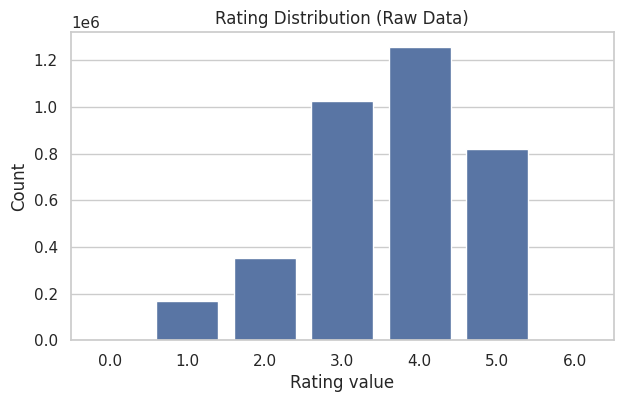

Rating value counts (including NaN):


rating
0.0        385
1.0     166369
2.0     354148
3.0    1026947
4.0    1256745
5.0     817530
6.0        376
NaN     402500
Name: count, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [168]:
vr = raw["viewer_ratings"]

plt.figure(figsize=(7,4))
sns.countplot(x="rating", data=vr)
plt.title("Rating Distribution (Raw Data)")
plt.xlabel("Rating value")
plt.ylabel("Count")
plt.savefig("images/rating_distribution_vr.png", dpi=300, bbox_inches="tight")
plt.show()

# Numeric check
print("Rating value counts (including NaN):")
display(vr["rating"].value_counts(dropna=False).sort_index())

files.download("images/rating_distribution_vr.png")


### Diagnostic Plot 2 — Number of Ratings per Year

We analyze the temporal distribution of ratings to understand how user activity evolves over time and to identify dataset boundary effects.

The plot displays a rapid increase in ratins starting in 2000 with a peak in 2004/2005 and a drop in 2006. This peak could possible be attributed to an increased user base or more content becoming available.
(the dataset is only supposed to contain movies up to 2006)

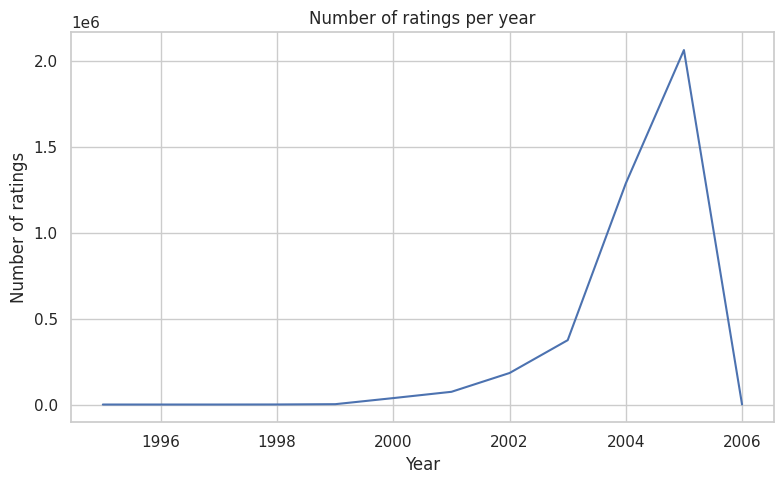

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [170]:
# Work on raw data
vr = raw["viewer_ratings"].copy()

# Ensure date is datetime
vr["date"] = pd.to_datetime(vr["date"], errors="coerce")

# Extract year
vr["year"] = vr["date"].dt.year

# Count ratings per year
ratings_per_year = vr.groupby("year").size()

# Plot
plt.figure()
ratings_per_year.plot(kind="line")
plt.xlabel("Year")
plt.ylabel("Number of ratings")
plt.title("Number of ratings per year")
plt.tight_layout()
plt.savefig("images/num_ratings_vr.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/num_ratings_vr.png")


### Diagnostic Plot 3 — Distribution of Ratings per User

We analyze the distribution of user activity to assess whether rating behavior is evenly distributed or dominated by a small number of highly active users.


The distribution is highly right-skewed, indicating that most users provide only a few ratings, while a small number of users are highly active. This sparsity is typical of user-generated rating datasets and contributes to the inherent noise in prediction tasks.

Users: 438570
Movies: 16013


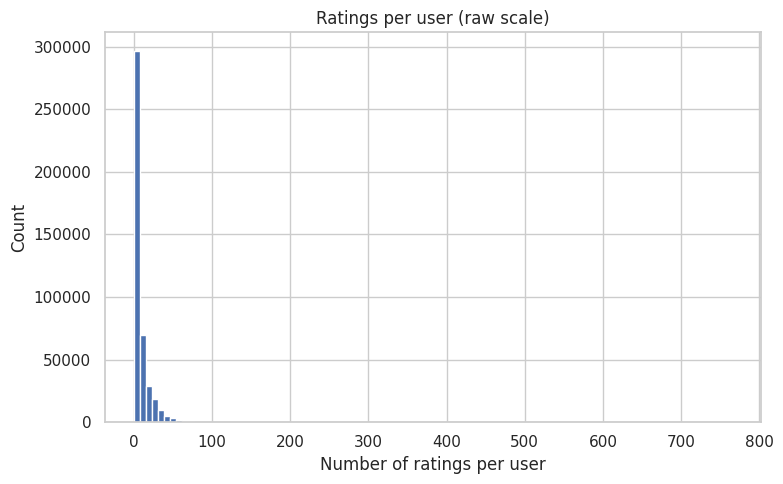

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [171]:
# Work on raw viewer_ratings
vr = raw["viewer_ratings"].copy()

# Ratings per user
ratings_per_user = vr.groupby("customer_id").size()

# Ratings per movie
ratings_per_movie = vr.groupby("movie_id").size()

print("Users:", ratings_per_user.shape[0])
print("Movies:", ratings_per_movie.shape[0])

plt.figure()
plt.hist(ratings_per_user, bins=100)
plt.xlabel("Number of ratings per user")
plt.ylabel("Count")
plt.title("Ratings per user (raw scale)")
plt.tight_layout()
plt.savefig("images/ratings_per_user.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/ratings_per_user.png")


###Diagnostic Plot 4 — Missing Values Overview

We inspect missing values across columns to identify expected missingness and non-informative fields prior to cleaning.

This visualization shows that missing values in the `viewer_ratings` table are concentrated in only two columns. The rating column contains a substantial number of missing values, which is expected and likely reflects normal user behavior where interactions occur without an explicit rating.

In contrast, the `anomalous_date` column is almost entirely missing, indicating that it does not provide meaningful information for analysis. All identifier and date fields are complete, which confirms the structural integrity of the dataset

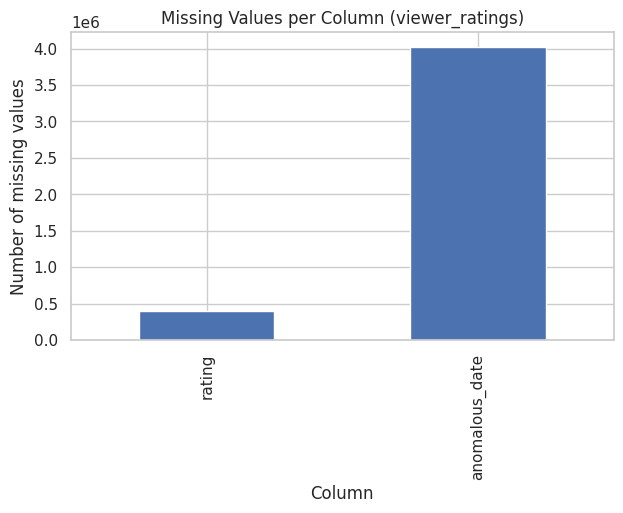

rating             402500
anomalous_date    4023791
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [172]:
vr = raw["viewer_ratings"]

missing_counts = vr.isna().sum()

plt.figure(figsize=(7,4))
missing_counts[missing_counts > 0].plot(kind="bar")
plt.title("Missing Values per Column (viewer_ratings)")
plt.ylabel("Number of missing values")
plt.xlabel("Column")
plt.savefig("images/miss_values_vr.png", dpi=300, bbox_inches="tight")
plt.show()

# Numeric check
display(missing_counts[missing_counts > 0])
files.download("images/miss_values_vr.png")


### Plot 5 - User Engagement and Probability of Leaving a Rating

After data cleaning, we examine the relationship between user engagement and the likelihood of providing explicit ratings. This code aims to visualize the relationship between user activity and their feedback behavior. Specifically, it answers the question:

> As users interact more with the platform, are they more or less likely to leave a formal rating?



The plot shows that even users with high levels of engagement do not consistently leave ratings for every interaction. While more active users have more opportunities to provide feedback, rating behavior remains selective across all engagement levels. This observation suggests that missing ratings are a common and expected aspect of user behavior rather than a data quality issue. Accordingly, missing ratings are treated as implicit feedback rather than values to be imputed.


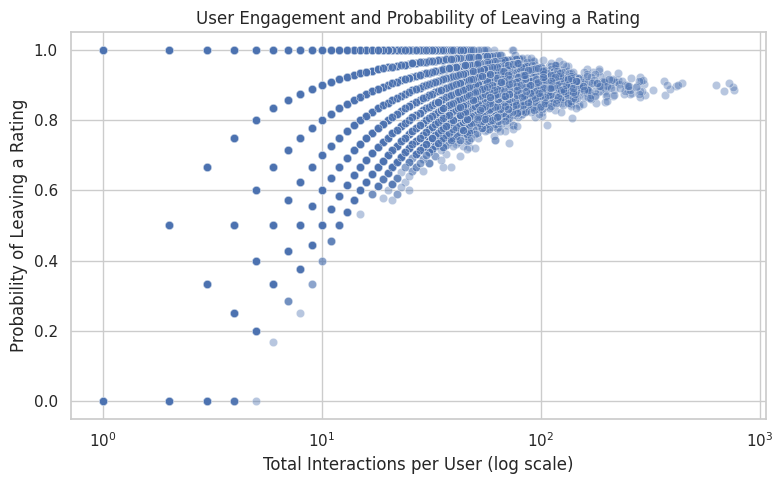

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [218]:
# Compute user-level engagement and rating behavior
engagement = (
    vr
    .assign(has_rating=vr["rating"].notna().astype(int))
    .groupby("customer_id")
    .agg(
        total_interactions=("rating", "size"),
        total_ratings=("has_rating", "sum")
    )
    .reset_index()
)

# Probability of leaving a rating
engagement["rating_probability"] = (
    engagement["total_ratings"] / engagement["total_interactions"]
)

# Plot
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=engagement,
    x="total_interactions",
    y="rating_probability",
    alpha=0.4
)

plt.xscale("log")
plt.xlabel("Total Interactions per User (log scale)")
plt.ylabel("Probability of Leaving a Rating")
plt.title("User Engagement and Probability of Leaving a Rating")

plt.tight_layout()
plt.savefig("images/engagement_rating.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/engagement_rating.png")


## Inspecting User Statistics table

The `user_statistics` table contains aggregated information at the user level, where each row represents a user and summarizes their rating behavior over time. It includes activity measures (number of ratings, number of unique movies), rating statistics, and temporal information about when users were active.

This overview is used to identify potential data quality issues before cleaning. In particular, it highlights:

- Aggregated rating values outside the valid range [1–5]
- Missing values for users with limited activity (e.g. undefined standard deviation or averages)

- Large variation in user activity levels

- Absence of duplicate rows or negative values

These observations help distinguish normal missing values from invalid aggregated values, guiding the cleaning decisions applied in the next steps.

In [173]:
us = raw["user_statistics"]

print("="*90)
print("TABLE: user_statistics")
print("Shape:", us.shape)

display(us.head(5))

print("\nInfo:")
us.info(memory_usage="deep")

print("\nDescribe (numeric):")
display(us.describe())

print("\nDescribe (categorical):")
display(us.describe(include=["object", "category"]))

print("\nMissing values (top):")
miss = us.isna().sum().sort_values(ascending=False)
display(miss[miss > 0])

print("\nFull-row duplicates:", us.duplicated().sum())

print("\nNegative values check (numeric columns):")
num_cols = us.select_dtypes(include=[np.number]).columns
neg_counts = (us[num_cols] < 0).sum().sort_values(ascending=False)
display(neg_counts[neg_counts > 0])



TABLE: user_statistics
Shape: (438780, 10)


customer_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0      1965326            8.0    3.250000    0.886405         2.0         5.0   
1       506434            1.0    4.000000         NaN         4.0         4.0   
2      1365167            3.0    4.666667    0.577350         4.0         5.0   
3       396632            2.0         NaN    0.000000         4.0         4.0   
4       260614            3.0    4.333333    0.577350         4.0         5.0   

   unique_movies first_rating_date last_rating_date  activity_days  
0            8.0        2004-08-11       2005-06-06          299.0  
1            1.0        2005-08-02       2005-08-02            0.0  
2            3.0        2004-11-16       2005-01-19           64.0  
3            2.0        2004-07-07       2004-07-07            0.0  
4            3.0        2004-03-02       2004-10-13            NaN


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438780 entries, 0 to 438779
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        438780 non-null  int64  
 1   total_ratings      416841 non-null  float64
 2   avg_rating         416841 non-null  float64
 3   std_rating         332528 non-null  float64
 4   min_rating         416841 non-null  float64
 5   max_rating         416841 non-null  float64
 6   unique_movies      416841 non-null  float64
 7   first_rating_date  438780 non-null  object 
 8   last_rating_date   438780 non-null  object 
 9   activity_days      416841 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 76.2 MB

Describe (numeric):


customer_id  total_ratings     avg_rating     std_rating  \
count  4.387800e+05  416841.000000  416841.000000  332528.000000   
mean   1.324053e+06       9.287268       3.632195       0.897624   
std    7.657258e+05      14.298646       0.812457       0.457394   
min    6.000000e+00       1.000000       0.000000       0.000000   
25%    6.603030e+05       2.000000       3.185185       0.645497   
50%    1.322018e+06       4.000000       3.687500       0.867759   
75%    1.987120e+06      11.000000       4.000000       1.154701   
max    2.997166e+06     764.000000       6.000000       3.535534   

          min_rating     max_rating  unique_movies  activity_days  
count  416841.000000  416841.000000  416841.000000  416841.000000  
mean        2.597285       4.413973       9.234881     275.437246  
std         1.217156       0.920667      13.406546     389.072857  
min         0.000000       0.000000       1.000000       0.000000  
25%         2.000000       4.000000       2.000000       0.000000  
50%         3.000000       5.000000       4.000000     102.000000  
75%         3.000000       5.000000      11.000000     408.000000  
max         6.000000       6.000000     764.000000    3941.000000


Describe (categorical):


first_rating_date last_rating_date
count             438780           438780
unique              3043             2998
top           2005-01-19       2005-10-24
freq                2818             2073


Missing values (top):


std_rating       106252
total_ratings     21939
unique_movies     21939
avg_rating        21939
min_rating        21939
max_rating        21939
activity_days     21939
dtype: int64


Full-row duplicates: 0

Negative values check (numeric columns):


Series([], dtype: int64)

###Diagnostic Plot 1 — Missing Values (user_statistics)

We visualize missing values in the `user_statistics` table to assess whether missingness arises from limited user activity or indicates data quality issues.

The figure shows that missing values are present in some aggregated user-level statistics. Importantly, all identifier fields (such as user and movie IDs) and temporal variables are complete, indicating that the table is structurally sound and suitable for further analysis.

/tmp/ipython-input-2474704598.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x400 with 0 Axes>

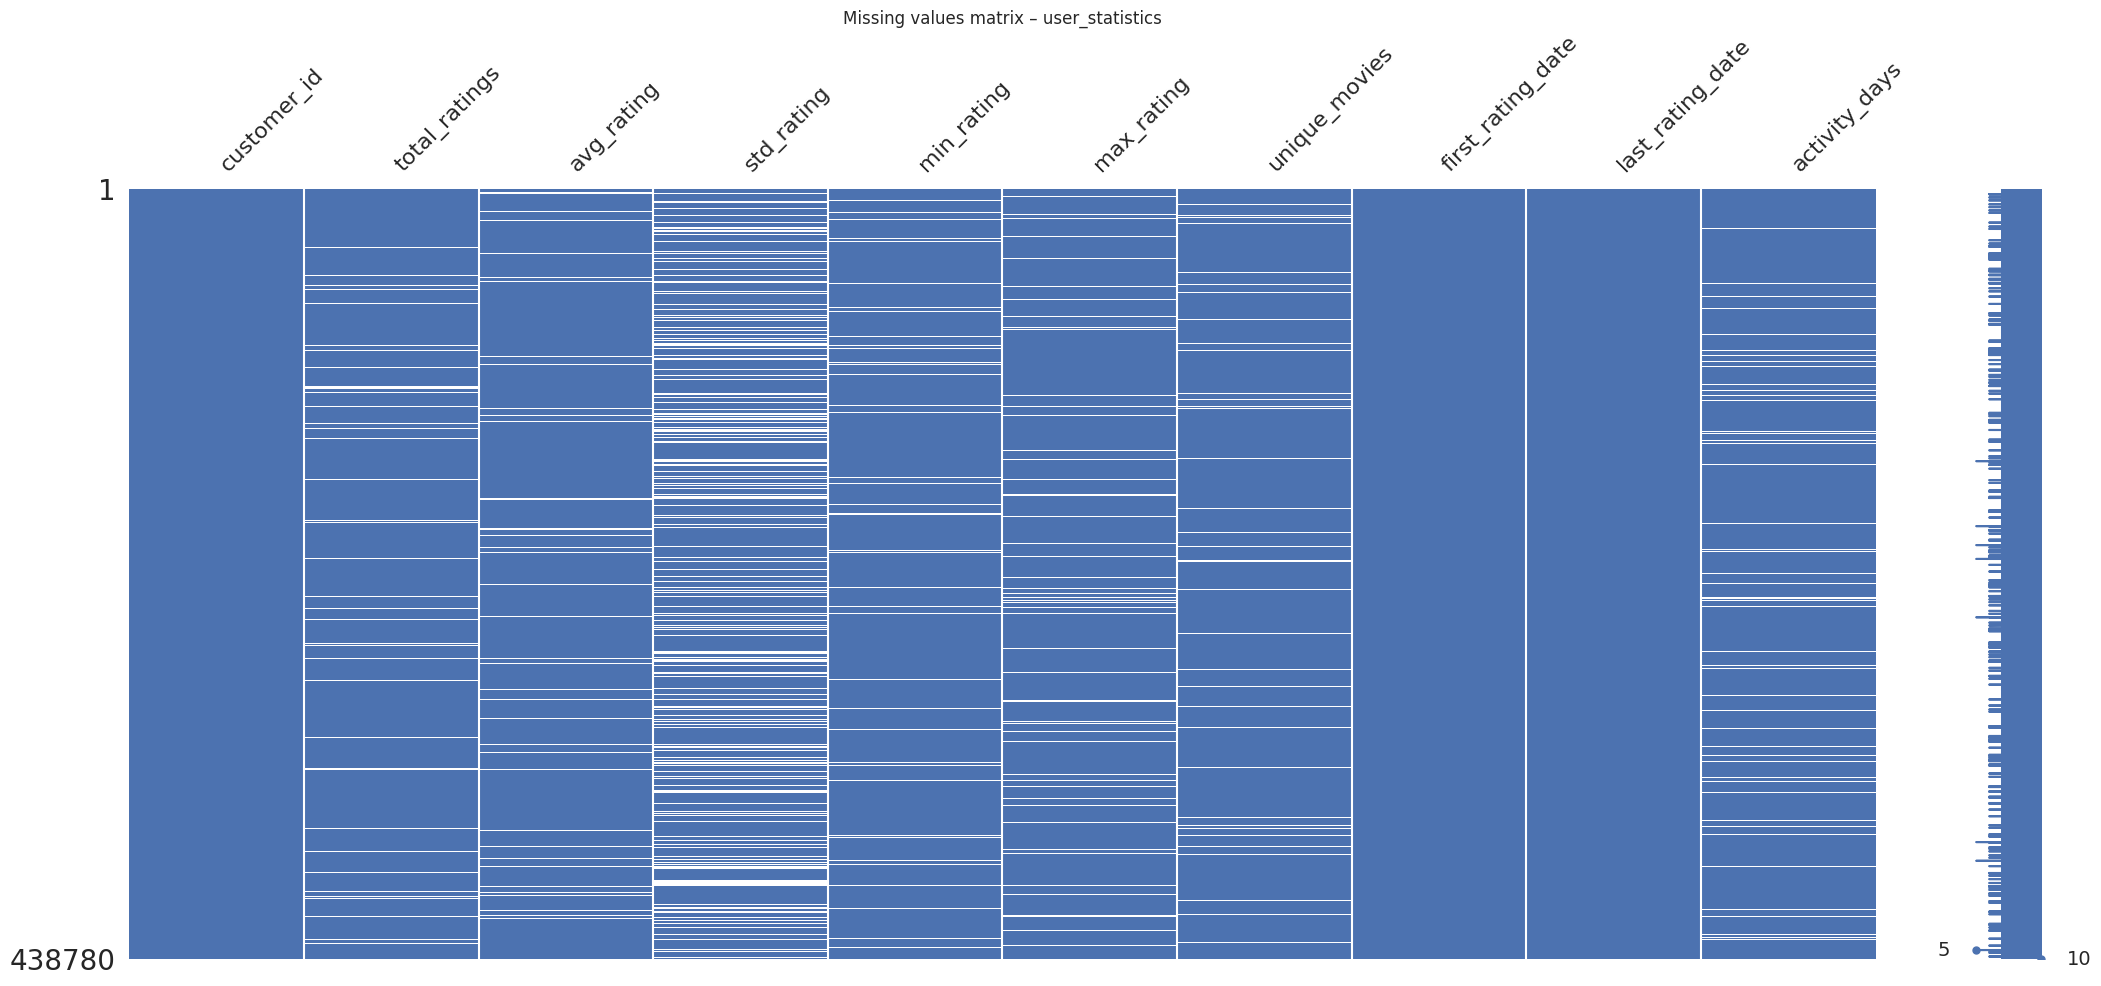

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [174]:
palette = sns.color_palette()
plt.figure(figsize=(10, 4))
msno.matrix(
    us,
    color=palette[0]
)
plt.title("Missing values matrix – user_statistics")
plt.tight_layout()
plt.savefig("images/miss_values_us.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/miss_values_us.png")


###Diagnostic Plot 2 — User Activity Distribution

To understand user engagement patterns in the dataset, we analyze the distribution of the total number of ratings provided by each user. This helps identify whether extreme values correspond to anomalous behavior or to genuinely highly active users.


The distribution of total ratings per user is highly right-skewed, with most users providing only a small number of ratings and a small group of users being very active. These extreme values reflect highly engaged users rather than data anomalies and are therefore retained.

A logarithmic scale is applied to the x-axis to better visualize this long-tailed behavior, which is typical in recommendation datasets.


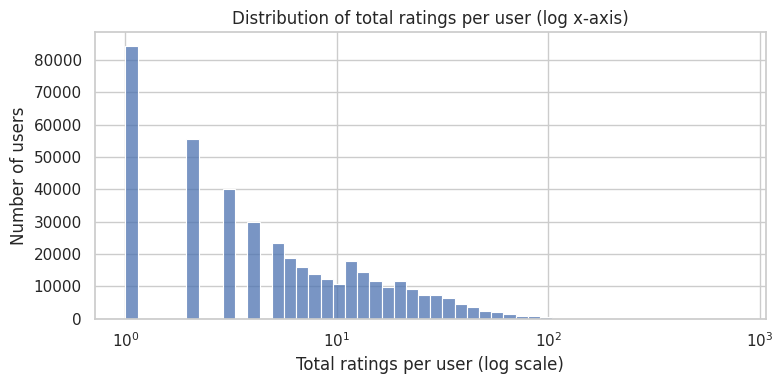

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [175]:
plt.figure(figsize=(8, 4))
sns.histplot(us["total_ratings"], bins=50, log_scale=True)
plt.xlabel("Total ratings per user (log scale)")
plt.ylabel("Number of users")
plt.title("Distribution of total ratings per user (log x-axis)")
plt.tight_layout()
plt.savefig("images/distribution_total_ratings_us.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/distribution_total_ratings_us.png")

###Diagnostic Plot 3 — Relationship Between User Activity and Average Rating

To assess whether user engagement level is associated with differences in rating behavior, we examine the relationship between user activity and average rating scores. Each point represents a user, with activity measured by the total number of ratings provided.


The plot shows that users with few ratings display highly variable average scores, reflecting instability due to limited observations. As activity increases, average ratings become more concentrated, indicating greater behavioral consistency.

In addition, highly active users tend to assign slightly lower average ratings, suggesting increased selectivity with experience. Overall, the plot reveals a clear association between engagement intensity and rating behavior, supporting the use of both activity and rating based features in user clustering.

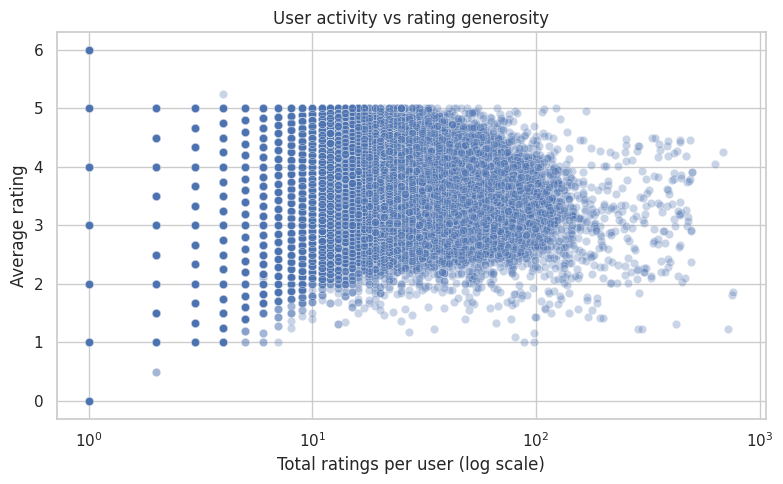

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [176]:
plot_df = us[["total_ratings", "avg_rating"]]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=plot_df,
    x="total_ratings",
    y="avg_rating",
    alpha=0.3
)

plt.xscale("log")
plt.xlabel("Total ratings per user (log scale)")
plt.ylabel("Average rating")
plt.title("User activity vs rating generosity")
plt.tight_layout()
plt.savefig("images/activity_generosity.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/activity_generosity.png")


###Diagnostic Plot 4 — Correlation Heatmap of User-Level Features
To examine relationships between user-level behavioral features in the `user_statistics` table, we analyze the correlation structure among key aggregated variables. This helps assess whether different measures of engagement and rating behavior capture distinct aspects of user behavior or largely overlap.


The correlation heatmap shows that `total_ratings` and `unique_movies` have a very strong positive correlation (0.97). This indicates that users who give many ratings also tend to rate many different movies, suggesting that repeatedly rating the same movies is not a dominant behavior. As a result, activity intensity and content diversity largely describe the same engagement pattern.

In contrast, the weak negative correlation between `avg_rating` and `total_ratings` indicates that how much users rate is largely independent of how generously they rate.


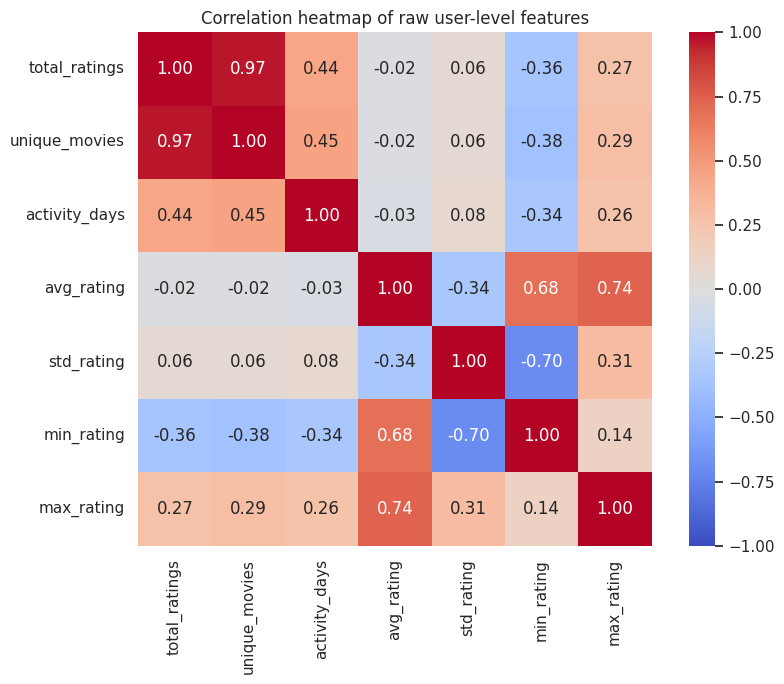

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [177]:
# Select raw numeric behavioral features only
corr_cols = [
    "total_ratings",
    "unique_movies",
    "activity_days",
    "avg_rating",
    "std_rating",
    "min_rating",
    "max_rating",
]

corr_df = us[corr_cols]


# Compute correlation matrix
corr = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    square=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)

plt.title("Correlation heatmap of raw user-level features")
plt.tight_layout()
plt.savefig("images/us_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/us_correlation.png")

## Inspecting Movies table

The movies table contains basic information about each movie, including its title and year of release. Each row represents one movie and is mainly used as a reference table when working with ratings and statistics.

A quick check shows that the release years fall within a realistic range and that there are no duplicate movies. Only a few release years are missing, which likely reflects missing metadata rather than data errors. Overall, this table is clean and requires minimal processing.

In [178]:
df = raw["movies"]

print("="*90)
print(f"TABLE: {name}")
print("Shape:", df.shape)

display(df.head(5))

print("\nInfo:")
df.info(memory_usage="deep")

print("\nDescribe (numeric):")
display(df.describe())

print("\nDescribe (categorical):")
display(df.describe(include=["object", "category"]))

print("\nMissing values (top):")
miss = df.isna().sum().sort_values(ascending=False)
display(miss[miss > 0])

print("\nFull-row duplicates:", df.duplicated().sum())


TABLE: data_dictionary
Shape: (18008, 3)


movie_id  year_of_release                         title
0         1           2003.0               Dinosaur Planet
1         2           2004.0    Isle of Man TT 2004 Review
2         3           1997.0                     Character
3         4           1994.0  Paula Abdul's Get Up & Dance
4         5           2004.0      The Rise and Fall of ECW


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18008 entries, 0 to 18007
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         18008 non-null  int64  
 1   year_of_release  18001 non-null  float64
 2   title            18008 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5 MB

Describe (numeric):


movie_id  year_of_release
count  18008.000000     18001.000000
mean    9048.736562      1990.232543
std     5293.394384        16.445821
min        1.000000      1896.000000
25%     4502.750000      1985.000000
50%     9004.500000      1997.000000
75%    13506.250000      2002.000000
max    24974.000000      2005.000000


Describe (categorical):


title
count                         18008
unique                        17579
top     The Hunchback of Notre Dame
freq                              6


Missing values (top):


year_of_release    7
dtype: int64


Full-row duplicates: 0


## Inspecting Movie Statistics table

The `movie_statistics` table contains aggregated information at the movie level, where each row represents a movie and summarizes how users have rated it. The table includes metadata (such as title and release year), engagement metrics (number of ratings and unique users), rating statistics, and the time span during which the movie received ratings.

This initial overview is used to check for data quality issues before cleaning. In particular, it highlights:

- Aggregated rating values outside the valid range [1–5]

- Missing values caused by limited user activity (e.g. undefined standard deviation)

- Highly uneven rating counts across movies

- Absence of duplicate rows

In [180]:
ms = raw["movie_statistics"]

print("="*90)
print("TABLE: movie_statistics")
print("Shape:", ms.shape)

display(ms.head(5))

print("\nInfo:")
ms.info(memory_usage="deep")

print("\nDescribe (numeric):")
display(ms.describe())

print("\nDescribe (categorical):")
display(ms.describe(include=["object", "category"]))

print("\nMissing values (top):")
miss = ms.isna().sum().sort_values(ascending=False)
display(miss[miss > 0])

print("\nFull-row duplicates:", ms.duplicated().sum())

print("\nAverage rating range check (expected 1–5):")
display(ms["avg_rating"].describe())
print("Invalid avg_rating count:",
      ((ms["avg_rating"] < 1) | (ms["avg_rating"] > 5)).sum())


TABLE: movie_statistics
Shape: (16015, 11)


movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0         1          548.0    3.744526    1.073389         1.0         5.0   
1         2          146.0    3.547945    1.281606         1.0         5.0   
2         3         2013.0    3.639841    0.978873         1.0         5.0   
3         4          142.0    2.739437    1.302913         1.0         5.0   
4         5         1140.0    3.919298    1.292436         1.0         5.0   

   unique_users first_rating_date last_rating_date  year_of_release  \
0         548.0        2003-07-12       2005-12-30           2003.0   
1         146.0        2004-10-16       2005-12-20           2004.0   
2        2013.0        2000-10-19       2005-12-30           1997.0   
3         142.0        2003-12-06       2005-12-27           1994.0   
4        1140.0        2004-11-02       2005-12-29           2004.0   

                          title  
0               Dinosaur Planet  
1    Isle of Man TT 2004 Review  
2                     Character  
3  Paula Abdul's Get Up & Dance  
4      The Rise and Fall of ECW


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16015 entries, 0 to 16014
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           16015 non-null  int64  
 1   total_ratings      15215 non-null  float64
 2   avg_rating         15215 non-null  float64
 3   std_rating         6847 non-null   float64
 4   min_rating         15215 non-null  float64
 5   max_rating         15215 non-null  float64
 6   unique_users       15215 non-null  float64
 7   first_rating_date  16015 non-null  object 
 8   last_rating_date   16015 non-null  object 
 9   year_of_release    11504 non-null  float64
 10  title              11508 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 3.7 MB

Describe (numeric):


movie_id  total_ratings    avg_rating   std_rating    min_rating  \
count  16015.000000   15215.000000  15215.000000  6847.000000  15215.000000   
mean   12502.830784     260.044167      2.999851     1.257923      2.478278   
std     7256.200931    3696.938525      1.312297     0.788635      1.489073   
min        1.000000       1.000000      0.000000     0.000000      0.000000   
25%     6204.500000       1.000000      2.000000     0.707107      1.000000   
50%    12486.000000       1.000000      3.000000     1.221699      2.000000   
75%    18831.500000       2.000000      4.000000     1.732051      4.000000   
max    25000.000000  173598.000000      6.000000     4.242641      6.000000   

         max_rating   unique_users  year_of_release  
count  15215.000000   15215.000000     11504.000000  
mean       3.497930     251.864344      1990.219750  
std        1.504205    3631.045822        16.333508  
min        0.000000       1.000000      1896.000000  
25%        2.000000       1.000000      1985.000000  
50%        4.000000       1.000000      1997.000000  
75%        5.000000       2.000000      2002.000000  
max        6.000000  173598.000000      2005.000000


Describe (categorical):


first_rating_date last_rating_date           title
count              16015            16015           11508
unique              3018             2765           11317
top           2000-01-05       2005-12-31  American Night
freq                  21              284               3


Missing values (top):


std_rating         9168
year_of_release    4511
title              4507
unique_users        800
avg_rating          800
total_ratings       800
min_rating          800
max_rating          800
dtype: int64


Full-row duplicates: 0

Average rating range check (expected 1–5):


count    15215.000000
mean         2.999851
std          1.312297
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: avg_rating, dtype: float64

Invalid avg_rating count: 362


####Diagnostic Plot 1 — Movie Popularity Distribution

To assess whether attention is evenly distributed across movies, we examine the distribution of the total number of ratings received by each movie. This allows us to identify potential popularity imbalances and long-tailed behavior.


The distribution is extremely right-skewed, indicating that attention is concentrated on a small number of blockbuster movies, while most movies receive relatively few ratings. This long-tailed pattern suggests that the majority of movies are niche in terms of audience engagement.

The logarithmic scale helps visualize this strong popularity imbalance, which is typical in movie recommendation datasets.


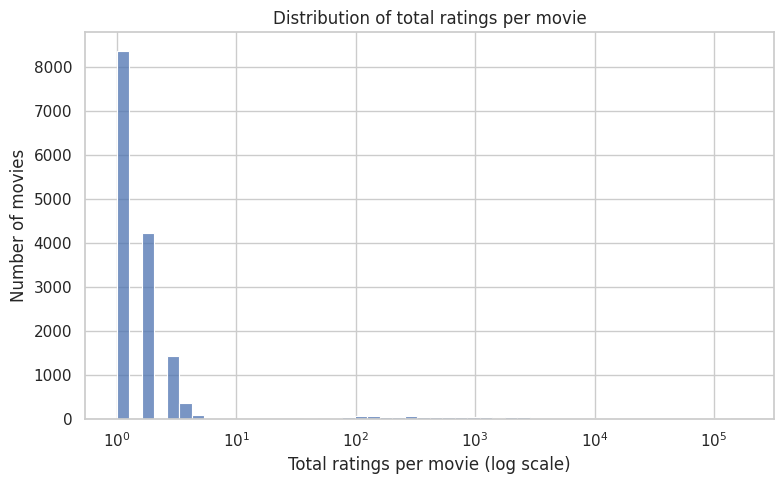

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [181]:
plt.figure()
sns.histplot(ms["total_ratings"], bins=50, log_scale=True)
plt.xlabel("Total ratings per movie (log scale)")
plt.ylabel("Number of movies")
plt.title("Distribution of total ratings per movie")
plt.tight_layout()
plt.savefig("images/distribution_ratings_movie.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/distribution_ratings_movie.png")


### Diagnostic Plot 2 — Average Movie Rating Distribution

To verify the validity of aggregated movie-level ratings, we examine the distribution of average ratings computed in the `movie_statistics` table. This helps identify whether invalid values are present in the raw aggregated data.


The distribution of average movie ratings shows that, while most values lie within the expected range of 1 to 5, a number of observations fall outside this interval. The numeric summary confirms the presence of theoretically impossible values, with minimum and maximum average ratings of 0 and 6, respectively. In total, 362 movies exhibit invalid average ratings.

This indicates that inconsistencies in the raw rating data propagate to aggregated statistics, highlighting the need to validate and clean both raw and derived tables before further analysis.


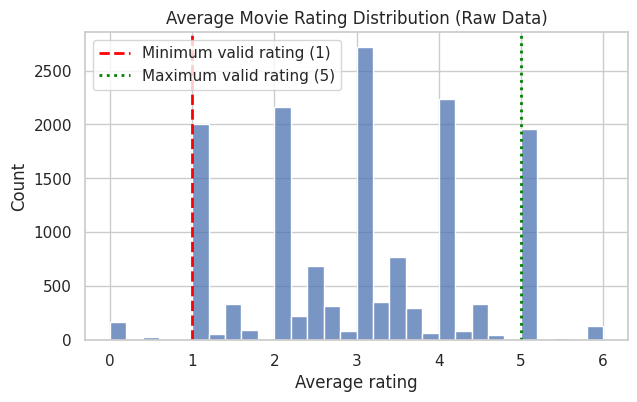

count    15215.000000
mean         2.999851
std          1.312297
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: avg_rating, dtype: float64

Invalid average ratings count: 362


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [182]:
plt.figure(figsize=(7,4))
sns.histplot(ms["avg_rating"], bins=30)

# Minimum valid rating
plt.axvline(
    1,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Minimum valid rating (1)"
)

# Maximum valid rating
plt.axvline(
    5,
    color="green",
    linestyle=":",
    linewidth=2,
    label="Maximum valid rating (5)"
)

plt.title("Average Movie Rating Distribution (Raw Data)")
plt.xlabel("Average rating")
plt.ylabel("Count")
plt.legend()
plt.savefig("images/average_movie_rating.png", dpi=300, bbox_inches="tight")
plt.show()

# Numeric support (keep this, it strengthens interpretation)
display(ms["avg_rating"].describe())
print(
    "Invalid average ratings count:",
    ((ms["avg_rating"] < 1) | (ms["avg_rating"] > 5)).sum()
)


files.download("images/average_movie_rating.png")

### Diagnostic Plot 4 — Correlation Heatmap of Movie-Level Features

To assess relationships between key movie-level features, we examine a correlation heatmap constructed from aggregated statistics in the `movie_statistics` table. This allows us to identify potential dependencies or redundancies between features prior to clustering.


The correlation heatmap shows that the selected movie-level features are largely independent. In particular, `total_ratings`, which represents movie popularity, exhibits near-zero correlation with `avg_rating`, `std_rating`, and `activity_span_days`. This suggests that how popular a movie is is largely independent of how well it is rated, how controversial it is, or how long it remains active.

The limited correlation between features is a positive signal for clustering, as it reduces redundancy and allows different dimensions of movie behavior to contribute meaningfully to the segmentation.


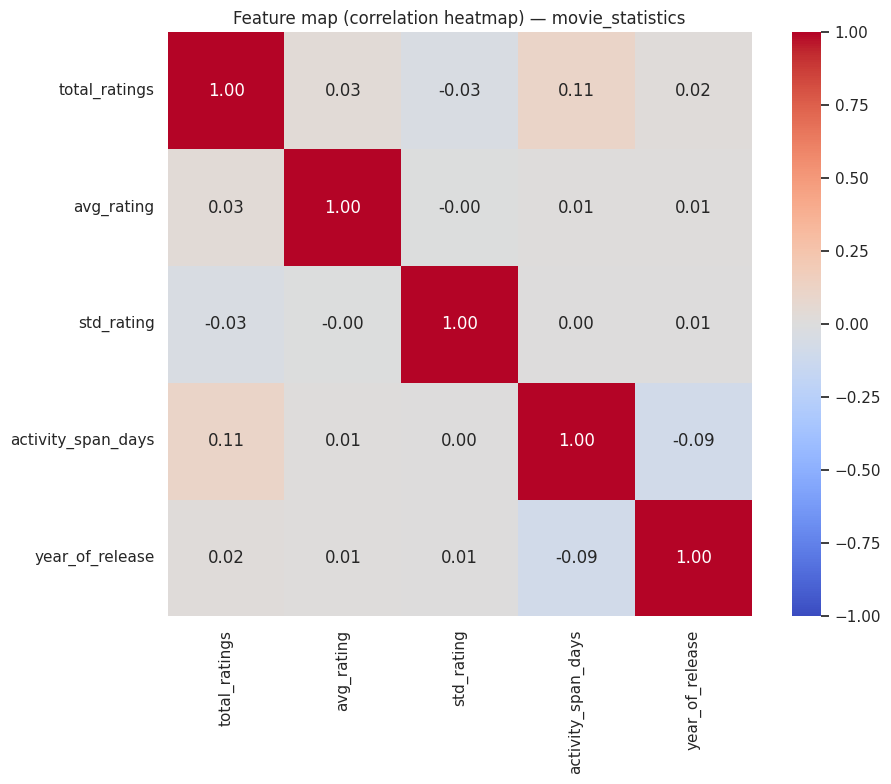

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [183]:
# Ensure dates are datetime
ms["first_rating_date"] = pd.to_datetime(ms["first_rating_date"], errors="coerce")
ms["last_rating_date"] = pd.to_datetime(ms["last_rating_date"], errors="coerce")

# Compute activity span (longevity) in days
ms["activity_span_days"] = (ms["last_rating_date"] - ms["first_rating_date"]).dt.days

# Select "important" numeric features
feat_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "activity_span_days",
    "year_of_release",
]

feat_df = ms[feat_cols]
corr = feat_df.corr()

# Plot correlation heatmap (feature map)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    square=True,
    cmap="coolwarm"
)
plt.title("Feature map (correlation heatmap) — movie_statistics")
plt.tight_layout()
plt.savefig("images/ms_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/ms_correlation.png")


## Inspecting Data Dictionary table

This table provides a structured description of all tables and fields contained in the dataset. It explains what each column represents, its data type, and how it should be interpreted.

In [ ]:
dd = raw["data_dictionary"]

print("="*90)
print("TABLE: data_dictionary")
print("Shape:", dd.shape)

display(dd)

print("\nInfo:")
dd.info(memory_usage="deep")

print("\nTables documented:")
display(dd["table_name"].value_counts())


TABLE: data_dictionary
Shape: (31, 4)


table_name         field_name data_type  \
0     viewer_ratings           movie_id   integer   
1     viewer_ratings        customer_id   integer   
2     viewer_ratings             rating   integer   
3     viewer_ratings               date      date   
4             movies           movie_id   integer   
5             movies    year_of_release   integer   
6             movies              title    string   
7    user_statistics        customer_id   integer   
8    user_statistics      total_ratings   integer   
9    user_statistics         avg_rating     float   
10   user_statistics         std_rating     float   
11   user_statistics         min_rating   integer   
12   user_statistics         max_rating   integer   
13   user_statistics      unique_movies   integer   
14   user_statistics  first_rating_date      date   
15   user_statistics   last_rating_date      date   
16   user_statistics      activity_days   integer   
17  movie_statistics           movie_id   integer   
18  movie_statistics              title    string   
19  movie_statistics    year_of_release   integer   
20  movie_statistics      total_ratings   integer   
21  movie_statistics         avg_rating     float   
22  movie_statistics         std_rating     float   
23  movie_statistics         min_rating   integer   
24  movie_statistics         max_rating   integer   
25  movie_statistics       unique_users   integer   
26  movie_statistics  first_rating_date      date   
27  movie_statistics   last_rating_date      date   
28         _metadata    dataset_version    string   
29         _metadata      academic_year    string   
30         _metadata       last_updated      date   

                                          description  
0   Unique movie identifier (1-17770 for original ...  
1   Anonymous customer identifier (1-2649429 with ...  
2             Rating score (1-5 stars, integers only)  
3   Date when rating was given (YYYY-MM-DD, range:...  
4                             Unique movie identifier  
5   Year of DVD release (1890-2005, may differ fro...  
6   Movie title in English (Netflix titles, may di...  
7                       Anonymous customer identifier  
8               Total number of ratings given by user  
9                        Average rating given by user  
10                      Standard deviation of ratings  
11                               Minimum rating given  
12                               Maximum rating given  
13                      Number of unique movies rated  
14                               Date of first rating  
15                                Date of last rating  
16                 Days between first and last rating  
17                            Unique movie identifier  
18                                        Movie title  
19                                    Year of release  
20                   Total number of ratings received  
21                            Average rating received  
22                      Standard deviation of ratings  
23                            Minimum rating received  
24                            Maximum rating received  
25                   Number of unique users who rated  
26                               Date of first rating  
27                                Date of last rating  
28                                Luiss ML/AI-project  
29                                          2025-2026  
30                                         2005-12-31


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   table_name   31 non-null     object
 1   field_name   31 non-null     object
 2   data_type    31 non-null     object
 3   description  31 non-null     object
dtypes: object(4)
memory usage: 7.9 KB

Tables documented:


table_name
movie_statistics    11
user_statistics     10
viewer_ratings       4
movies               3
_metadata            3
Name: count, dtype: int64

# DATA CLEANING AND PREPARATION


---





####Create Safe Working Copies

To ensure reproducibility and preserve the original data used during EDA, we create deep copies of all tables before applying any cleaning operations.


In [184]:
data = {name: df.copy(deep=True) for name, df in raw.items()}
stamp("Deep copies created — cleaning starts")


[19:19:20] Deep copies created — cleaning starts | RAM(MB): 5765.0


## Cleaning viewer_ratings table

Even though there are several missing values in the `rating` column of the `viewer_ratings` table, we do not impute them. Missing ratings represent the absence of explicit user–movie feedback rather than unknown target values. Imputing these observations would introduce artificial labels and potentially bias model estimation.


In [185]:
# working refrences
vr = data["viewer_ratings"].copy()

print("Initial shape:", vr.shape)

print("Duplicate rows:", vr.duplicated().sum())

print(vr.isna().sum())


Initial shape: (4025000, 5)
Duplicate rows: 0
movie_id                0
customer_id             0
rating             402500
date                    0
anomalous_date    4023791
dtype: int64


The date column is converted to a datetime format to enable time-based analysis.

In [186]:
# Convert date to datetime
vr["date"] = pd.to_datetime(vr["date"], errors="coerce")

print("Date dtype after conversion:", vr["date"].dtype)
print("Missing dates after conversion:", vr["date"].isna().sum())


Date dtype after conversion: datetime64[ns]
Missing dates after conversion: 0


Invalid rating values outside the [1–5] range are treated as missing values, as imputing them would introduce artificial information and bias the data.


In [187]:
# Handle invalid rating values
invalid_mask = (vr["rating"] < 1) | (vr["rating"] > 5)

print("Invalid ratings BEFORE:", invalid_mask.sum())

vr.loc[invalid_mask, "rating"] = np.nan

print(
    "Invalid ratings AFTER:",
    ((vr["rating"] < 1) | (vr["rating"] > 5)).sum()
)


Invalid ratings BEFORE: 761
Invalid ratings AFTER: 0


In [188]:
# Validate ratings
display(vr["rating"].value_counts(dropna=False).sort_index())


rating
1.0     166369
2.0     354148
3.0    1026947
4.0    1256745
5.0     817530
NaN     403261
Name: count, dtype: int64

The `anomalous_date` column is removed because over 99.9% of its values are missing, providing no meaningful information for analysis or modeling.


In [189]:
# dropping anomalous_date column as 99.9% of the data is missing
vr = vr.drop(columns=["anomalous_date"])

print("Remaining columns:", vr.columns.tolist())


Remaining columns: ['movie_id', 'customer_id', 'rating', 'date']


In [190]:
# dropping Nans so the table can be used for prediction
vr = vr.dropna(subset=["rating"])
print(vr.isna().sum())

movie_id       0
customer_id    0
rating         0
date           0
dtype: int64


In [191]:
# Final validation
print("Final shape:", vr.shape)
print("Duplicate rows:", vr.duplicated().sum())

vr.info(memory_usage="deep")
display(vr.describe())

viewer_ratings_clean = vr.copy()

# FINAL CLEAN TABLE FOR VIEWER_RATINGS = viewer_ratings_clean


Final shape: (3621739, 4)
Duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
Index: 3621739 entries, 0 to 4024999
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movie_id     int64         
 1   customer_id  int64         
 2   rating       float64       
 3   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 138.2 MB


movie_id   customer_id        rating                           date
count  3.621739e+06  3.621739e+06  3.621739e+06                        3621739
mean   6.909755e+03  1.321920e+06  3.608801e+00  2004-09-30 19:20:06.895031040
min    1.000000e+00  6.000000e+00  1.000000e+00            1995-01-02 00:00:00
25%    4.503000e+03  6.600960e+05  3.000000e+00            2004-05-05 00:00:00
50%    9.217000e+03  1.317838e+06  4.000000e+00            2005-01-09 00:00:00
75%    1.337500e+04  1.984101e+06  4.000000e+00            2005-06-29 00:00:00
max    2.500000e+04  2.649429e+06  5.000000e+00            2006-03-28 00:00:00
std    5.032458e+03  7.646147e+05  1.077407e+00                            NaN

The `viewer_ratings` table was cleaned by correcting data types, handling invalid rating values, and removing non-informative columns. Ratings outside the valid range of 1 to 5 were treated as invalid measurements and converted to missing values, while existing missing ratings were dropped in order to be used for prediction and clustering. The date column was converted to a datetime format, and a column with extreme missingness (`anomalous_date`) was removed. No duplicate records were identified.


###Distribution of Ratings After Cleaning

After cleaning the `viewer_ratings` table, we visualize the distribution of ratings to verify that all remaining values fall within the expected 1–5 scale and to obtain a baseline view of the cleaned rating data.


The plot confirms that all ratings in the cleaned dataset lie within the valid range from 1 to 5, indicating that invalid values were successfully removed. Missing ratings are excluded from the visualization, as they correspond to users who did not provide a rating. The distribution shows a higher concentration of mid-to-high ratings, providing an initial indication of how users tend to evaluate movies in the cleaned data.


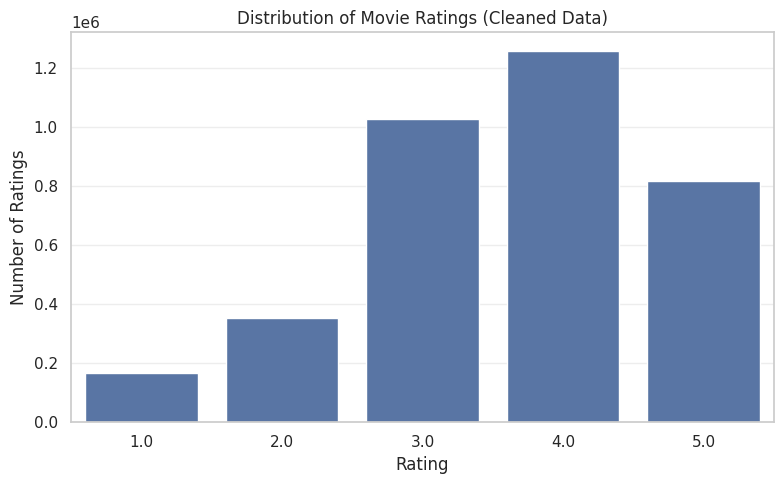

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [192]:
vr = data["viewer_ratings"].copy()

# Drop missing ratings
vr_clean = vr[vr["rating"].notna()]

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=vr_clean,
    x="rating",
    order=[1.0, 2.0, 3.0, 4.0, 5.0]
)

plt.title("Distribution of Movie Ratings (Cleaned Data)")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")

plt.grid(True, axis="y", alpha=0.35)
plt.tight_layout()
plt.savefig("images/cleaned_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/cleaned_distribution.png")


## Cleaning movies table

The `movies` table contains basic metadata for each movie. Cleaning focuses on removing duplicate movie identifiers and handling a small number of missing release years, while preserving the overall structure of the table.


In [196]:
# Create working reference
mv = data["movies"].copy()

print("Initial shape:", mv.shape)

# Dublicate check
print("Duplicate rows:", mv.duplicated().sum())
print("Duplicate movie IDs:", mv.duplicated("movie_id").sum()) # 2 duplicate movie_ids
mv = mv.drop_duplicates(subset="movie_id", keep="first").reset_index(drop=True)

# Handle missing year_of_release
print(mv.isna().sum())



Initial shape: (18008, 3)
Duplicate rows: 0
Duplicate movie IDs: 2
movie_id           0
year_of_release    7
title              0
dtype: int64


Because only a small number of movies (7 rows) have missing release years, these records are removed. This has a negligible impact on the dataset and avoids introducing unnecessary assumptions through imputation.


In [197]:
# Dropping Nans in year_of_realease column
mv = mv.dropna(subset=["year_of_release"])
print(mv.isna().sum())

movie_id           0
year_of_release    0
title              0
dtype: int64


In [198]:
# Validate year range
# All dates are already in between 1896 - 2005 as described in the data dictionary
mv["year_of_release"].describe()


count    17999.000000
mean      1990.233846
std         16.446201
min       1896.000000
25%       1985.000000
50%       1997.000000
75%       2002.000000
max       2005.000000
Name: year_of_release, dtype: float64

The movies table contains basic movie information such as title and release year and was already mostly clean. A small number of duplicate movie entries (2 rows) were identified and removed. Release years fall within a realistic range, and only a very small number of movies (7) were missing a release year; these records were dropped due to their negligible impact on the dataset.


In [199]:
# Final validation
print("Final shape:", mv.shape)
mv.info(memory_usage="deep")
display(mv.describe())


# FINAL TABLE FOR MOVIES mv

Final shape: (17999, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 17999 entries, 0 to 18005
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         17999 non-null  int64  
 1   year_of_release  17999 non-null  float64
 2   title            17999 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6 MB


movie_id  year_of_release
count  17999.000000     17999.000000
mean    9046.662315      1990.233846
std     5292.106360        16.446201
min        1.000000      1896.000000
25%     4501.500000      1985.000000
50%     9003.000000      1997.000000
75%    13503.500000      2002.000000
max    24974.000000      2005.000000

## Cleaning user_statistics table

The `user_statistics` table contains aggregated user-level metrics derived from individual ratings. Missing values in these aggregates arise primarily from incomplete or inconsistent aggregation in the raw dataset. To ensure consistency with the cleaned `viewer_ratings` table, missing aggregate values are recomputed directly from the cleaned raw ratings data.


In [200]:
# Create working reference
user_statistics = data["user_statistics"].copy()

print("Duplicate rows:", user_statistics.duplicated().sum())

viewer_ratings = viewer_ratings_clean.copy()

print("Missing values before imputation: ")
display(user_statistics.isna().sum().sort_values(ascending=False))
print(user_statistics.shape)

Duplicate rows: 0
Missing values before imputation: 


std_rating           106252
total_ratings         21939
unique_movies         21939
avg_rating            21939
min_rating            21939
max_rating            21939
activity_days         21939
customer_id               0
first_rating_date         0
last_rating_date          0
dtype: int64

(438780, 10)


In [201]:
# Convert date columns to datetime
user_statistics["first_rating_date"] = pd.to_datetime(user_statistics["first_rating_date"], errors="coerce")
user_statistics["last_rating_date"] = pd.to_datetime(user_statistics["last_rating_date"], errors="coerce")

print(user_statistics[["first_rating_date", "last_rating_date"]].dtypes)
print("Missing first_rating_date after conversion:", user_statistics["first_rating_date"].isna().sum())
print("Missing last_rating_date after conversion:", user_statistics["last_rating_date"].isna().sum())


first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
dtype: object
Missing first_rating_date after conversion: 0
Missing last_rating_date after conversion: 0


In [202]:
# Recompute missing values
customer_totals = viewer_ratings.groupby("customer_id")["rating"].count()
customer_unique = viewer_ratings.groupby("customer_id")["movie_id"].nunique()
customer_avg = viewer_ratings.groupby("customer_id")["rating"].mean()
customer_std = viewer_ratings.groupby("customer_id")["rating"].std()
customer_first = viewer_ratings.groupby("customer_id")["date"].min()
customer_last = viewer_ratings.groupby("customer_id")["date"].max()
customer_activity = (customer_last - customer_first).dt.days
customer_min_rating = viewer_ratings.groupby("customer_id")["rating"].min()
customer_max_rating = viewer_ratings.groupby("customer_id")["rating"].max()

# Replace missing values with the recomputed values
user_statistics["total_ratings"] = user_statistics["total_ratings"].fillna(user_statistics["customer_id"].map(customer_totals))
user_statistics["unique_movies"] = user_statistics["unique_movies"].fillna(user_statistics["customer_id"].map(customer_unique))
user_statistics["avg_rating"] = user_statistics["avg_rating"].fillna(user_statistics["customer_id"].map(customer_avg))
user_statistics["std_rating"] = user_statistics["std_rating"].fillna(user_statistics["customer_id"].map(customer_std))
user_statistics["activity_days"] = user_statistics["activity_days"].fillna(user_statistics["customer_id"].map(customer_activity))
user_statistics["min_rating"] = user_statistics["min_rating"].fillna(user_statistics["customer_id"].map(customer_min_rating))
user_statistics["max_rating"] = user_statistics["max_rating"].fillna(user_statistics["customer_id"].map(customer_max_rating))

# Missing values overview
print("Missing values after imputation: ")
display(user_statistics.isna().sum().sort_values(ascending=False))
print(user_statistics.shape)

Missing values after imputation: 


std_rating           89387
avg_rating             543
min_rating             526
max_rating             510
total_ratings          499
unique_movies          495
activity_days          473
customer_id              0
first_rating_date        0
last_rating_date         0
dtype: int64

(438780, 10)


In [203]:
# avg_rating must be within [1, 5]
invalid_avg = (user_statistics["avg_rating"] < 1) | (user_statistics["avg_rating"] > 5)
print("Invalid avg_rating:", invalid_avg.sum())
user_statistics.loc[invalid_avg, "avg_rating"] = np.nan

# min_rating must be within [1, 5]
invalid_min = (user_statistics["min_rating"] < 1) | (user_statistics["min_rating"] > 5)
print("Invalid min_rating:", invalid_min.sum())
user_statistics.loc[invalid_min, "min_rating"] = np.nan

# max_rating must be within [1, 5]
invalid_max = (user_statistics["max_rating"] < 1) | (user_statistics["max_rating"] > 5)
print("Invalid max_rating:", invalid_max.sum())
user_statistics.loc[invalid_max, "max_rating"] = np.nan

Invalid avg_rating: 663
Invalid min_rating: 734
Invalid max_rating: 727


For users who have provided only a single rating, the standard deviation of ratings is mathematically undefined. In these cases, the standard deviation is set to zero to reflect the absence of variability rather than missing information.


In [204]:
user_statistics.loc[user_statistics["total_ratings"] == 1, "std_rating"] = 0
display(user_statistics.isna().sum().sort_values(ascending=False))
print(user_statistics.shape)


min_rating           1260
max_rating           1237
avg_rating           1206
std_rating           1032
total_ratings         499
unique_movies         495
activity_days         473
customer_id             0
first_rating_date       0
last_rating_date        0
dtype: int64

(438780, 10)


After recomputation, a small number of missing values remain. Since clustering algorithms cannot operate on incomplete data, users with remaining missing values in key features are removed at this stage.


In [205]:
user_statistics_clean = user_statistics.dropna(subset=["avg_rating", "std_rating", "activity_days", "unique_movies", "total_ratings"])
display(user_statistics_clean.isna().sum().sort_values(ascending=False))
print(user_statistics_clean.shape)

min_rating           475
max_rating           449
total_ratings          0
customer_id            0
std_rating             0
avg_rating             0
unique_movies          0
first_rating_date      0
last_rating_date       0
activity_days          0
dtype: int64

(435769, 10)


The `user_statistics` table was cleaned by recomputing missing aggregate values directly from the cleaned `viewer_ratings` data, ensuring consistency across tables. Undefined standard deviations for users with a single rating were set to zero to reflect the absence of rating variability. Remaining incomplete records were removed to meet the requirements of clustering algorithms. The final table contains valid ranges, correct data types, and no duplicate entries, and is suitable for downstream modeling and clustering.


In [206]:
# Final validation
print("Final shape:", user_statistics_clean.shape)

user_statistics_clean.info(memory_usage="deep")
display(user_statistics_clean.describe())

# FINAL TABLE FOR USER_STATISTICS IS user_statistics_clean


Final shape: (435769, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 435769 entries, 0 to 438779
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        435769 non-null  int64         
 1   total_ratings      435769 non-null  float64       
 2   avg_rating         435769 non-null  float64       
 3   std_rating         435769 non-null  float64       
 4   min_rating         435294 non-null  float64       
 5   max_rating         435320 non-null  float64       
 6   unique_movies      435769 non-null  float64       
 7   first_rating_date  435769 non-null  datetime64[ns]
 8   last_rating_date   435769 non-null  datetime64[ns]
 9   activity_days      435769 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 36.6 MB


customer_id  total_ratings     avg_rating     std_rating  \
count  4.357690e+05  435769.000000  435769.000000  435769.000000   
mean   1.323784e+06       9.280841       3.633613       0.718191   
min    6.000000e+00       1.000000       1.000000       0.000000   
25%    6.601430e+05       2.000000       3.190476       0.000000   
50%    1.321668e+06       4.000000       3.685714       0.744024   
75%    1.986730e+06      11.000000       4.000000       1.057462   
max    2.997166e+06     764.000000       5.000000       3.535534   
std    7.656318e+05      14.057736       0.802176       0.543733   

          min_rating     max_rating  unique_movies  \
count  435294.000000  435320.000000  435769.000000   
mean        2.595101       4.418359       9.232486   
min         1.000000       1.000000       1.000000   
25%         2.000000       4.000000       2.000000   
50%         3.000000       5.000000       4.000000   
75%         3.000000       5.000000      11.000000   
max         5.000000       5.000000     764.000000   
std         1.210161       0.909104      13.294422   

                   first_rating_date               last_rating_date  \
count                         435769                         435769   
mean   2004-07-08 10:20:22.253074816  2005-04-11 13:25:55.322200576   
min              1995-01-01 00:00:00            1995-01-01 00:00:00   
25%              2004-01-07 00:00:00            2005-02-15 00:00:00   
50%              2004-11-30 00:00:00            2005-07-16 00:00:00   
75%              2005-06-22 00:00:00            2005-10-14 00:00:00   
max              2006-03-28 00:00:00            2006-03-28 00:00:00   
std                              NaN                            NaN   

       activity_days  
count  435769.000000  
mean      276.589833  
min         0.000000  
25%         0.000000  
50%       104.000000  
75%       410.000000  
max      3941.000000  
std       389.324614

## Cleaning movie_statistics table

The `movie_statistics` table contains aggregated movie-level metrics derived from individual ratings. Cleaning focuses on validating rating aggregates, recomputing missing values from the cleaned `viewer_ratings` table, and preparing the data for clustering.


In [207]:
# Create working reference
ms = data["movie_statistics"].copy()

print("Initial shape:", ms.shape)

# Missing values overview
display(ms.isna().sum().sort_values(ascending=False))

Initial shape: (16015, 12)


std_rating            9168
year_of_release       4511
title                 4507
total_ratings          800
unique_users           800
avg_rating             800
min_rating             800
max_rating             800
movie_id                 0
first_rating_date        0
last_rating_date         0
activity_span_days       0
dtype: int64

In [208]:
# Duplicate check
print("Duplicate rows:", ms.duplicated().sum())
print("Duplicate movie_id:", ms.duplicated("movie_id").sum())
ms = ms.drop_duplicates(subset="movie_id", keep="first").reset_index(drop=True)
print("Duplicate movie_id:", ms.duplicated("movie_id").sum())


Duplicate rows: 0
Duplicate movie_id: 2
Duplicate movie_id: 0


In [209]:
# Pre-clean sanity snapshot
display(ms.describe())


movie_id  total_ratings    avg_rating   std_rating    min_rating  \
count  16013.000000   15213.000000  15213.000000  6846.000000  15213.000000   
mean   12501.812902     260.078157      2.999785     1.258107      2.478144   
min        1.000000       1.000000      0.000000     0.000000      0.000000   
25%     6204.000000       1.000000      2.000000     0.707107      1.000000   
50%    12485.000000       1.000000      3.000000     1.222021      2.000000   
75%    18830.000000       2.000000      4.000000     1.732051      4.000000   
max    25000.000000  173598.000000      6.000000     4.242641      6.000000   
std     7256.071907    3697.180356      1.312258     0.788546      1.489025   

         max_rating   unique_users              first_rating_date  \
count  15213.000000   15214.000000                          16013   
mean       3.497929     251.880833  2002-05-30 05:46:45.495534848   
min        0.000000       1.000000            1995-01-01 00:00:00   
25%        2.000000       1.000000            2000-08-09 00:00:00   
50%        4.000000       1.000000            2002-07-22 00:00:00   
75%        5.000000       2.000000            2004-05-09 00:00:00   
max        6.000000  173598.000000            2006-03-28 00:00:00   
std        1.504205    3631.164590                            NaN   

                    last_rating_date  year_of_release  activity_span_days  
count                          16013     11502.000000        16013.000000  
mean   2003-09-07 04:54:14.455754624      1990.221788          464.963530  
min              1995-01-01 00:00:00      1896.000000            0.000000  
25%              2002-05-13 00:00:00      1985.000000            0.000000  
50%              2004-04-05 00:00:00      1997.000000            0.000000  
75%              2005-05-25 00:00:00      2002.000000          769.000000  
max              2006-03-28 00:00:00      2005.000000         4055.000000  
std                              NaN        16.334089          721.095462

In [210]:
# Convert date columns to datetime
ms["first_rating_date"] = pd.to_datetime(ms["first_rating_date"], errors="coerce")
ms["last_rating_date"] = pd.to_datetime(ms["last_rating_date"], errors="coerce")

print(ms[["first_rating_date", "last_rating_date"]].dtypes)


first_rating_date    datetime64[ns]
last_rating_date     datetime64[ns]
dtype: object


One way to deal with the missing values, similar to the approach we used in `user_statistics`, is to recompute the missing values using the data found in the `viewer_ratings` table.

In [211]:
viewer_ratings = vr.copy()
movies = mv.copy()

In [212]:
# Recompute missing values
movie_totals = viewer_ratings.groupby("movie_id")["rating"].count()
movie_avg = viewer_ratings.groupby("movie_id")["rating"].mean()
movie_std = viewer_ratings.groupby("movie_id")["rating"].std()
movie_min = viewer_ratings.groupby("movie_id")["rating"].min()
movie_max = viewer_ratings.groupby("movie_id")["rating"].max()
movie_unique_users = viewer_ratings.groupby("movie_id")["customer_id"].nunique()
movie_first = viewer_ratings.groupby("movie_id")["date"].min()
movie_last = viewer_ratings.groupby("movie_id")["date"].max()
year_map = movies.set_index("movie_id")["year_of_release"]

# Replace missing values with the recomputed values
ms["total_ratings"] = ms["total_ratings"].fillna(ms["movie_id"].map(movie_totals))
ms["unique_users"] = ms["unique_users"].fillna(ms["movie_id"].map(movie_unique_users))
ms["avg_rating"] = ms["avg_rating"].fillna(ms["movie_id"].map(movie_avg))
ms["std_rating"] = ms["std_rating"].fillna(ms["movie_id"].map(movie_std))
ms["first_rating_date"] = ms["first_rating_date"].fillna(ms["movie_id"].map(movie_first))
ms["last_rating_date"] = ms["last_rating_date"].fillna(ms["movie_id"].map(movie_last))
ms["year_of_release"] = ms["year_of_release"].fillna(ms["movie_id"].map(year_map))
ms["min_rating"] = ms["min_rating"].fillna(ms["movie_id"].map(movie_min))
ms["max_rating"] = ms["max_rating"].fillna(ms["movie_id"].map(movie_max))

# Missing values overview
display(ms.isna().sum().sort_values(ascending=False))
print(ms.shape)

std_rating            8856
year_of_release       4511
title                 4507
avg_rating              55
max_rating              49
min_rating              45
movie_id                 0
total_ratings            0
first_rating_date        0
unique_users             0
last_rating_date         0
activity_span_days       0
dtype: int64

(16013, 12)


Aggregated rating statistics are validated to ensure they fall within the valid rating scale [1–5]. Values outside this range are treated as missing rather than clipped, in order to avoid introducing artificial information.


In [213]:
# avg_rating must be within [1, 5]
invalid_avg = (ms["avg_rating"] < 1) | (ms["avg_rating"] > 5)
print("Invalid avg_rating:", invalid_avg.sum())
ms.loc[invalid_avg, "avg_rating"] = np.nan

# min_rating must be within [1, 5]
invalid_min = (ms["min_rating"] < 1) | (ms["min_rating"] > 5)
print("Invalid min_rating:", invalid_min.sum())
ms.loc[invalid_min, "min_rating"] = np.nan

# max_rating must be within [1, 5]
invalid_max = (ms["max_rating"] < 1) | (ms["max_rating"] > 5)
print("Invalid max_rating:", invalid_max.sum())
ms.loc[invalid_max, "max_rating"] = np.nan


Invalid avg_rating: 378
Invalid min_rating: 570
Invalid max_rating: 585


Due to 25% of `year_of_release` values being missing, dropping those rows would lead to too big of a loss of data, and imputation could lead to distorting the data, we have decided to add a "missing" flag.

In [214]:
# 1) Create missingness flag BEFORE imputation
ms["year_missing"] = ms["year_of_release"].isna().astype(int)

# 2) Impute using the mean
imputer = SimpleImputer(strategy="median")

ms["year_of_release"] = imputer.fit_transform(ms[["year_of_release"]])


The reason for so many Nans in `std_rating` is explained if `total_ratings` == 1. Due to the high number of missing Nans in `std_rating`, we are imputing them with 0 if the user has only rated once.

In [215]:
ms.loc[ms["total_ratings"] == 1, "std_rating"] = 0
display(ms.isna().sum().sort_values(ascending=False))
print(ms.shape)


title                 4507
max_rating             634
min_rating             615
avg_rating             433
std_rating              78
total_ratings            0
movie_id                 0
first_rating_date        0
unique_users             0
last_rating_date         0
year_of_release          0
activity_span_days       0
year_missing             0
dtype: int64

(16013, 13)


As the `title`, `max_rating` and `min_rating` will not be used in clustering or modelling as they are redundant, we are ignoring the Nans in those columns and dropping the remaining Nans in key features.

In [216]:
ms = ms.dropna(subset=["std_rating", "avg_rating", "total_ratings", "unique_users"])

display(ms.isna().sum().sort_values(ascending=False))


title                 4353
max_rating             283
min_rating             260
movie_id                 0
total_ratings            0
std_rating               0
avg_rating               0
first_rating_date        0
unique_users             0
last_rating_date         0
year_of_release          0
activity_span_days       0
year_missing             0
dtype: int64

The `movie_statistics` table contains aggregated metrics at the movie level. Missing values were expected for movies with limited activity and were therefore preserved. Sanity checks revealed some aggregated rating values outside the valid rating range, which were converted to missing values instead of removing movie records. Release years and other metadata were kept unchanged, as their values fall within realistic ranges. After cleaning, the table contains consistent rating statistics and is ready for analysis.

In [217]:
# Final validation
print("Final shape:", ms.shape)
print("Duplicate rows:", ms.duplicated().sum())

ms.info(memory_usage="deep")
display(ms.describe())

movie_statistics_clean = ms.copy()


# FINAL TABLE FOR MOVIES STATISTICS IS movie_statistics_clean

Final shape: (15508, 13)
Duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
Index: 15508 entries, 0 to 16012
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            15508 non-null  int64         
 1   total_ratings       15508 non-null  float64       
 2   avg_rating          15508 non-null  float64       
 3   std_rating          15508 non-null  float64       
 4   min_rating          15248 non-null  float64       
 5   max_rating          15225 non-null  float64       
 6   unique_users        15508 non-null  float64       
 7   first_rating_date   15508 non-null  datetime64[ns]
 8   last_rating_date    15508 non-null  datetime64[ns]
 9   year_of_release     15508 non-null  float64       
 10  title               11155 non-null  object        
 11  activity_span_days  15508 non-null  int64         
 12  year_missing        15508 non-null  int64         
dtypes: datet

movie_id  total_ratings   avg_rating    std_rating    min_rating  \
count  15508.000000   15508.000000  15508.00000  15508.000000  15248.000000   
mean   12495.085698     259.064934      3.00747      0.577575      2.513379   
min        1.000000       0.000000      1.00000      0.000000      1.000000   
25%     6192.500000       1.000000      2.00000      0.000000      1.000000   
50%    12494.000000       1.000000      3.00000      0.000000      2.000000   
75%    18815.250000       2.000000      4.00000      1.153465      4.000000   
max    25000.000000  173598.000000      5.00000      4.242641      5.000000   
std     7255.018937    3664.503389      1.24756      0.828160      1.417301   

         max_rating   unique_users              first_rating_date  \
count  15225.000000   15508.000000                          15508   
mean       3.478292     259.503289  2002-05-26 07:57:50.002579328   
min        1.000000       1.000000            1995-01-02 00:00:00   
25%        2.000000       1.000000            2000-08-05 00:00:00   
50%        4.000000       1.000000            2002-07-16 00:00:00   
75%        5.000000       2.000000            2004-05-06 00:00:00   
max        5.000000  173598.000000            2006-03-28 00:00:00   
std        1.422897    3665.111805                            NaN   

                    last_rating_date  year_of_release  activity_span_days  \
count                          15508     15508.000000        15508.000000   
mean   2003-09-12 15:38:01.454733056      1992.124194          474.319577   
min              1995-01-03 00:00:00      1896.000000            0.000000   
25%              2002-05-21 00:00:00      1991.000000            0.000000   
50%              2004-04-11 00:00:00      1997.000000            0.000000   
75%              2005-05-29 06:00:00      2000.000000          793.000000   
max              2006-03-28 00:00:00      2005.000000         4055.000000   
std                              NaN        14.184990          725.962432   

       year_missing  
count  15508.000000  
mean       0.280952  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  
std        0.449478

# **USER SEGMENTATION**

## Standardizing features

Before standardizing, due to some features displaying a strong right skew, log transformation was applied to highly skewed activity features to limit the
influence of extreme values and improve cluster stability.


The aim of the clustering analysis is to identify groups of users with similar
viewing and rating behaviors on the platform. Because the clustering we will perform is based on aggregated behavioral features derived from the
`user_statistics` table, we have decided to drop certain unnecessary or redundant features that will only increase the complexity of the model without adding much value. The following features were dropped:
- `customer_id` (has no behavioural meaning, just an identifier)
- `first_rating_date` (already summarized by activity_days and raw dates don't provide meaningful distances for clustering)
- `last_rating_date` (already summarized by activity_days and raw dates don't provide meaningful distances for clustering)
- `min_rating` (redundant)
- `max_rating` (redundant)


In [224]:
us = user_statistics_clean.copy()

# Dropping redundant columns
us = us.drop(columns=[
    "customer_id",
    "first_rating_date",
    "last_rating_date",
    "min_rating",
    "max_rating"
])

# Log transforming skewed features
us["total_ratings"] = np.log1p(us["total_ratings"])
us["activity_days"] = np.log1p(us["activity_days"])
us["unique_movies"] = np.log1p(us["unique_movies"])


In [225]:
# Standardizing features
X = us.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X.describe() #visualize the standardized values


total_ratings     avg_rating     std_rating  unique_movies  \
count  435769.000000  435769.000000  435769.000000  435769.000000   
mean        1.841621       3.633613       0.718191       1.841287   
std         0.933253       0.802176       0.543733       0.932274   
min         0.693147       1.000000       0.000000       0.693147   
25%         1.098612       3.190476       0.000000       1.098612   
50%         1.609438       3.685714       0.744024       1.609438   
75%         2.484907       4.000000       1.057462       2.484907   
max         6.639876       5.000000       3.535534       6.639876   

       activity_days  
count  435769.000000  
mean        3.667115  
std         2.721867  
min         0.000000  
25%         0.000000  
50%         4.653960  
75%         6.018593  
max         8.279443

# K-Means++ Clustering based on user_statistic

K-Means++ was selected to cluster `user_statistics` because it provides a robust and efficient initialization strategy for centroid-based clustering. By spreading initial centroids apart, K-Means++ reduces sensitivity to poor random initialization and improves convergence stability compared to standard K-Means. Additionally, K-Means++ scales well to large datasets and produces interpretable, compact clusters suitable for analysis and profiling.

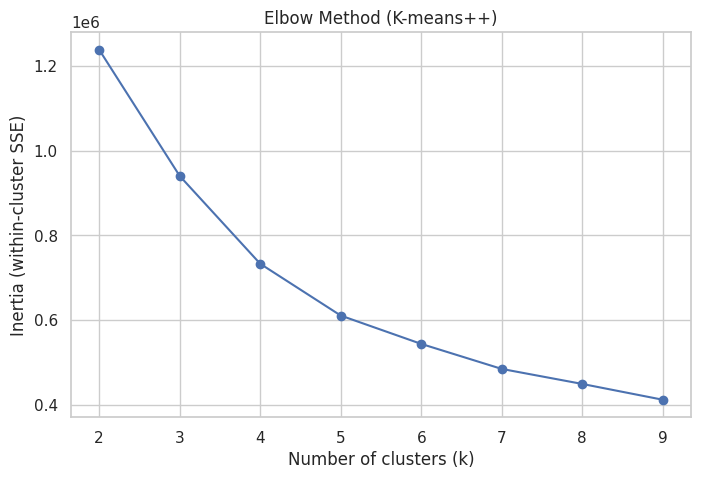

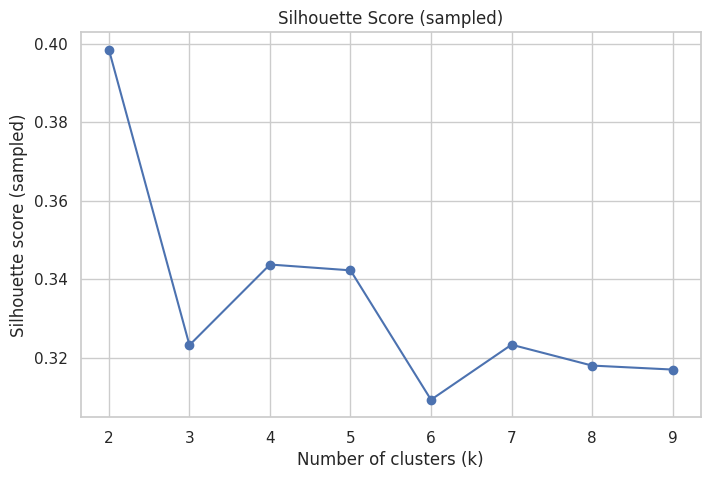

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [158]:
# K-Means++ clustering
k_range = range(2, 10)
inertias = []
silhouettes = []

# Creating a random sample once in order to calculate the silhouette score
rng = np.random.RandomState(55)
sample_size = 20000
sample_idx = rng.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sample = X_scaled[sample_idx]

for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=55)
    labels = km.fit_predict(X_scaled)

    # Elbow test on the full dataset
    inertias.append(km.inertia_)

    # Silhouette on the sample dataset
    labels_sample = labels[sample_idx]
    silhouettes.append(silhouette_score(X_sample, labels_sample))


# Plotting the Elbow method
plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method (K-means++)")
plt.savefig("images/elbow_method.png", dpi=300, bbox_inches="tight")
plt.show()

# Plotting Silhouette
plt.figure()
plt.plot(list(k_range), silhouettes, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score (sampled)")
plt.title("Silhouette Score (sampled)")
plt.savefig("images/silhouette.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/elbow_method.png")
files.download("images/silhouette.png")

According to the silhouette score, we should cluster users into 2 clusters, however this is too simplistic and not informative enough for our goal. Therefore we have picked **k = 5** to be a valid choice, balancing the silhouette score and the elbow method. With **inertia score: 610804** and **silhouette score: 0.342**

In [159]:
k5_index = list(k_range).index(5)

inertia_k5 = inertias[k5_index]
silhouette_k5 = silhouettes[k5_index]

print("Inertia (k=5):", inertia_k5)
print("Silhouette (k=5):", silhouette_k5)


Inertia (k=5): 610804.5488264011
Silhouette (k=5): 0.34224179401115407


# HDBSCAN clustering based on user_statistics

Hierarchical Density-Based Spatial Clustering of Applications with Noise is a density-based clustering algorithm that groups points that lie in dense regions, labelling sparse points as noise. The advantage over K-Means is that it does not require you to specify k number of clusters in advance.

HDBSCAN was selected over DBSCAN because it scales more efficiently to large datasets and does not require specifying a global density threshold, while still identifying noise and variable-density clusters.


In [ ]:
# Initializing HDBSCAN
# min_samples - controls how conservative the clustering is (higher = more noise)
hdb = HDBSCAN(min_cluster_size=20000, min_samples=100, cluster_selection_method="eom", n_jobs=-1)

# Fitting and predicting
hdb_labels = hdb.fit_predict(X_scaled)

# Sampling for silhouette score
sample_size = 40000
np.random.seed(55)
idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)

X_sample = X_scaled[idx]
labels_sample = hdb_labels[idx]

# Removing noise points (-1) for silhouette calculation
masks = labels_sample != -1
X_clustered = X_sample[masks]
labels = labels_sample[masks]

# Evaluation
n_clusters = len(set(labels))

if n_clusters > 1 and len(X_clustered) > 0:
    sil = silhouette_score(X_clustered, labels)

    print(f"Number of clusters found (excluding noise): {n_clusters}")
    print(f"Silhouette score (excluding noise): {sil:.4f}")

    # Calculates noise percentage
    noise_ratio = np.sum(hdb_labels == -1) / len(hdb_labels)
    print(f"Percentage of users labeled as 'Noise': {noise_ratio:.2%}")
else:
    print("Unable to compute silhouette score: less than 2 non-noise clusters found.")


Number of clusters found (excluding noise): 4
Silhouette score (excluding noise): 0.3155
Percentage of users labeled as 'Noise': 11.28%


# Clustering through an Autoencoder + K-Means on user_statistics

User statistics were first standardized and compressed using an autoencoder trained to reconstruct the input data. The resulting low-dimensional latent representation captures the main patterns in user behavior while reducing noise and feature redundancy. K-Means clustering was then applied to this latent space to obtain compact and interpretable user segments.

An autoencoder is an ANN that takes an input X -> compresses it into a hidden representation -> reconstructs the original input from that compressed version. Consists of an encoder (compression) and a decoder (reconstruction).



In [ ]:
def run_autoencoder_clustering(data, name="Dataset", n_clusters=5):

    # Scaling the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    input_dim = X_scaled.shape[1]

    # Building an autoencoder (functional API)
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    bottleneck = Dense(4, activation='relu', name='bottleneck')(encoded) # Compresses to 4 features

    # Decoder
    decoded = Dense(16, activation='relu')(bottleneck)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Compile
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Training (it is self-supervised meaning X_scaled is the input and the target)
    print(f"Training Autoencoder for {name}...")
    history = autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=32, verbose=0)

    # Extracting latent features
    encoder_model = Model(inputs=autoencoder.input, outputs=bottleneck)
    latent_features = encoder_model.predict(X_scaled)

    # Applying K-Means++ to latent features
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    clusters = kmeans.fit_predict(latent_features)

    return clusters, latent_features, history

In [ ]:
clusters, latent_features, _ = run_autoencoder_clustering(us, "User Stats", n_clusters=5)
us['cluster'] = clusters

Training Autoencoder for User Stats...
13618/13618 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step


In [ ]:
# Same sampling strategy as normal K-Means
rng = np.random.RandomState(55)
sample_size = 20000
sample_idx = rng.choice(latent_features.shape[0], size=sample_size, replace=False)

Z_sample = latent_features[sample_idx]
labels_sample = clusters[sample_idx]

silhouette_ae = silhouette_score(Z_sample, labels_sample)

print("Silhouette (Autoencoder + KMeans, k=5):", silhouette_ae)


Silhouette (Autoencoder + KMeans, k=5): 0.34267777


### Comparing Silhouette Scores

As the bar plot shows, the Autoencoder + K-Means has a better silhouette score but as the difference is very slight, we will be opting for the normal K-Means++ clustering algorithm due to its simplicity, speed when dealing with large datasets and its interpretability. There is only a marginal improement with the Autoencoder + K-Means method that is not worth the trade-off in complexity.

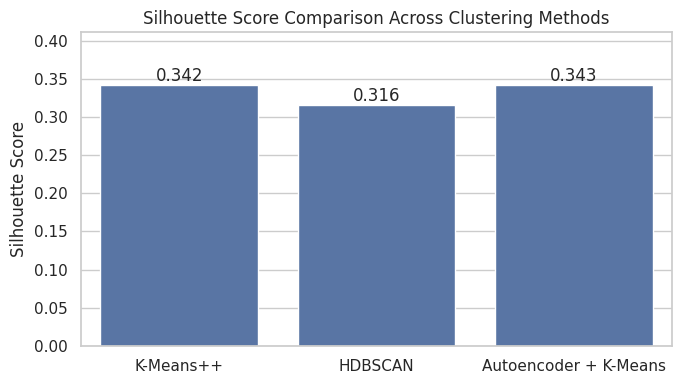

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [220]:
silhouette_results = pd.DataFrame({"Method": [
        "K-Means++",
        "HDBSCAN",
        "Autoencoder + K-Means"
    ],
    "Silhouette Score": [
        0.34224179401115407,      # silhouette from k-means++
        0.3155,     # HDBSCAN
        0.34267777    # autoencoder
]})


plt.figure(figsize=(7, 4))
sns.barplot(
    data=silhouette_results,
    x="Method",
    y="Silhouette Score"
)

plt.title("Silhouette Score Comparison Across Clustering Methods")
plt.ylabel("Silhouette Score")
plt.xlabel("")
plt.ylim(0, silhouette_results["Silhouette Score"].max() * 1.2)

for i, v in enumerate(silhouette_results["Silhouette Score"]):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")

plt.tight_layout()
plt.savefig("images/silhouette_score_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/silhouette_score_comparison.png")


# Fitting the model on K-means++

In [226]:
kmeans_us = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=10,
    random_state=42
)
label_us = kmeans_us.fit_predict(X_scaled)

# Attach labels to user_statistics dataframe (us)
us = us.copy()
us["cluster"] = label_us

# Implementing PCA
Principal Component Analysis is included as a dimension-reduction technique, in order to turn the features from a 5 dimensional space (which we wouldn't be able to plot) into 2 dimensions for visualization purposes.


Explained variance ratio (PC1, PC2): [0.59212712 0.20959466]
Total explained variance (2 PCs): 0.8017217784794004


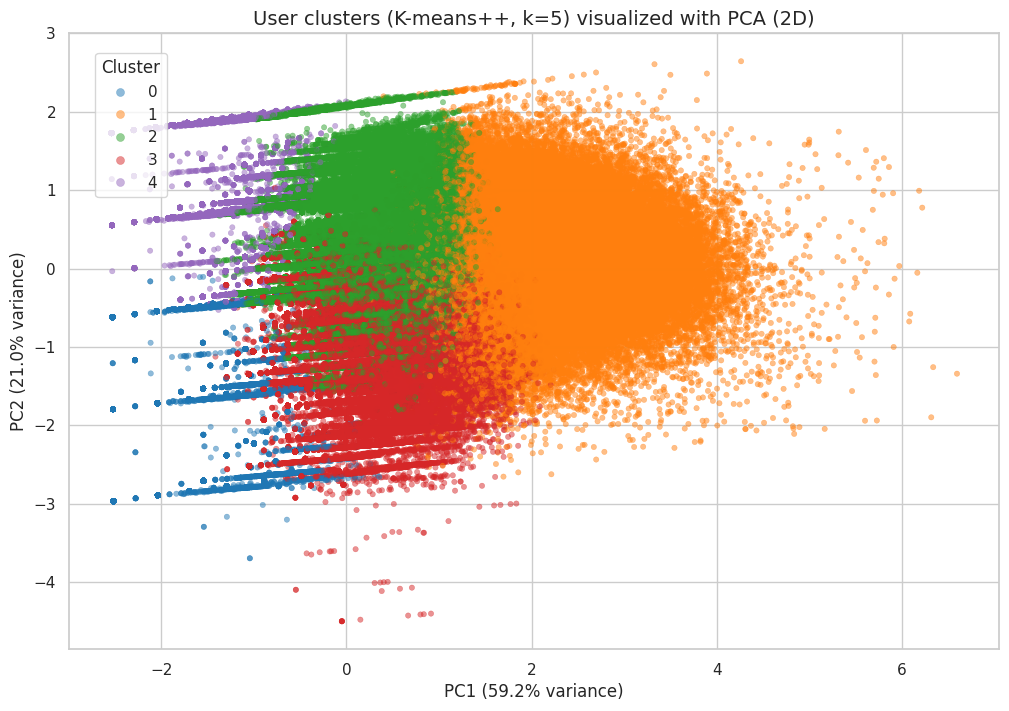

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [227]:
pca_us = PCA(n_components=2, random_state=42)
X_pca_us = pca_us.fit_transform(X_scaled)

us["pca1"] = X_pca_us[:, 0]
us["pca2"] = X_pca_us[:, 1]

print("Explained variance ratio (PC1, PC2):", pca_us.explained_variance_ratio_)
print("Total explained variance (2 PCs):", pca_us.explained_variance_ratio_.sum())

plt.figure(figsize=(12, 8))

plot = sns.scatterplot(data=us, x="pca1", y="pca2", hue="cluster", palette="tab10", s=15, alpha=0.5, edgecolor=None)

plt.legend(title="Cluster", loc='upper left', bbox_to_anchor=(0.02, 0.98), frameon=True, markerscale=1.5)

plt.title("User clusters (K-means++, k=5) visualized with PCA (2D)", fontsize=14)
plt.xlabel(f"PC1 ({pca_us.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca_us.explained_variance_ratio_[1]:.1%} variance)")

plt.savefig("images/users_cluster_pca.png", dpi=300, bbox_inches="tight")
plt.show()

features_used = ["avg_rating", "std_rating", "total_ratings", "activity_days", "unique_movies"]

# Cluster sizes
cluster_sizes_us = us["cluster"].value_counts().sort_index()
cluster_shares_us = (cluster_sizes_us / cluster_sizes_us.sum()).round(4)

# Means (easy to interpret)
cluster_means_us = us.groupby("cluster")[features_used].mean()

# Medians (robust to skew, often better for engagement variables)
cluster_medians_us = us.groupby("cluster")[features_used].median()

# Combine into one table
segmentation = cluster_means_us.add_prefix("mean_").join(
    cluster_medians_us.add_prefix("median_")
)
segmentation["n_users"] = cluster_sizes_us
segmentation["share_users"] = cluster_shares_us

files.download("images/users_cluster_pca.png")


## Audience Segmentation: Cluster Interpretation

The audience clustering identifies 5 distinct viewer archetypes based on engagement intensity, rating behavior, and selectivity:

- 🟦 **Cluster 0 – Disengaged Low-Rating Users (≈11%)**   
Very low activity and content diversity, with below-average ratings and minimal variability, indicating short-lived or unsatisfactory platform use. This conclusion is justified by them having the lowest `mean_avg_rating` and low `mean_activity_days`.

- 🟧 **Cluster 1 – Highly Active Exploratory Viewers (≈27%)**   
  The most engaged users, characterized by long activity spans, high consumption breadth, and balanced rating behavior. This conclusion is justified by them having the highest `mean_total_ratings` and `mean_activity_days`.

- 🟩 **Cluster 2 – Consistent Positive Regulars (≈28%)**    
  Regularly active users who provide consistently high ratings with moderate variability, reflecting stable and generally positive viewing habits. This conclusion is justified by sitting comfortably in the middle for activity but maintain a high average rating with low variance.

- 🟥 **Cluster 3 – Moderate but Critical Viewers (≈15%)**    
  Moderately active users with the highest rating variability, suggesting selective and more critical evaluation of content. This conclusion is justified by them having the highest `mean_std_rating`, meaning their ratings swing wildly between high and low.

- 🟪 **Cluster 4 – Generous Casual Enthusiasts (≈19%)**    
  Low-engagement users who rate content very highly with little variance, indicating sporadic but enthusiastic interaction. This is justified by them having the highest `mean_avg_rating` but very low activity and almost zero rating variance, meaning they show up rarely but give 5 stars when they do.

In [228]:
segmentation

mean_avg_rating  mean_std_rating  mean_total_ratings  \
cluster                                                         
0               2.320275         0.064159            0.797540   
1               3.596884         0.952972            3.081681   
2               3.908107         0.715197            1.817361   
3               3.209194         1.481275            1.572817   
4               4.401112         0.157491            0.922061   

         mean_activity_days  mean_unique_movies  median_avg_rating  \
cluster                                                              
0                  0.323963            0.798172           2.585714   
1                  5.964512            3.080546           3.600000   
2                  5.090663            1.817116           4.000000   
3                  3.481752            1.571896           3.250000   
4                  0.381020            0.922647           4.250000   

         median_std_rating  median_total_ratings  median_activity_days  \
cluster                                                                  
0                 0.000000              0.693147              0.000000   
1                 0.937102              2.995732              6.198479   
2                 0.707107              1.791759              5.332719   
3                 1.414214              1.609438              4.189655   
4                 0.000000              0.693147              0.000000   

         median_unique_movies  n_users  share_users  
cluster                                              
0                    0.693147    48570       0.1115  
1                    2.995732   118354       0.2716  
2                    1.791759   120916       0.2775  
3                    1.609438    65936       0.1513  
4                    0.693147    81993       0.1882

# **CONTENT SEGMENTATION**

The goal of content segmentation is to identify groups of movies with similar audience reception and consumption patterns. Due to not having explicit genres, we are clustering movies together using aggregated behavioural features like popularity, average rating, rating variability, and longevity, in order to uncover meaningful content profiles that reflect how audiences perceive and engage with different types of movies.

We are dropping the following features in order to reduce complexity:
- `first_rating_date`: euclidean distances between dates is hard to interpret, redundant as already summarised by `activity_span_days`
- `last_rating_date`:  euclidean distances between dates is hard to interpret, redundant as already summarised by `activity_span_days`
- `min_rating`: redundant given `avg_rating` and `std_rating`
- `max_rating`: redundant given `avg_rating` and `std_rating`
- `movie_id`: no behavioural meaning, just an identifier
- `title`: categorical, would require encoding

In [126]:
ms = movie_statistics_clean.copy()

ms = ms.drop(columns=[
    "first_rating_date",
    "last_rating_date",
    "min_rating",
    "max_rating",
    "movie_id",
    "title"
])

# log tranforming skewed features
ms["total_ratings"] = np.log1p(ms["total_ratings"])
ms["unique_users"] = np.log1p(ms["unique_users"])

X = ms.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ms.isna().sum()

total_ratings         0
avg_rating            0
std_rating            0
unique_users          0
year_of_release       0
activity_span_days    0
year_missing          0
dtype: int64

Plotting elbow method and silhouette score, due to our table having 15543 rows, there is no need to create a sample for the silhouette score.

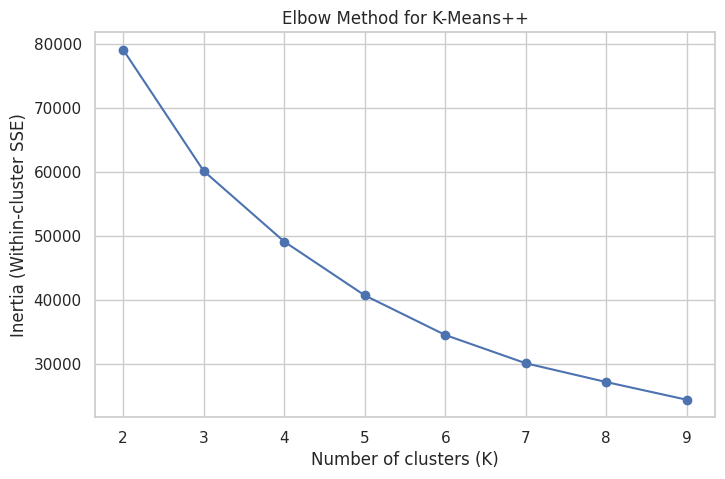

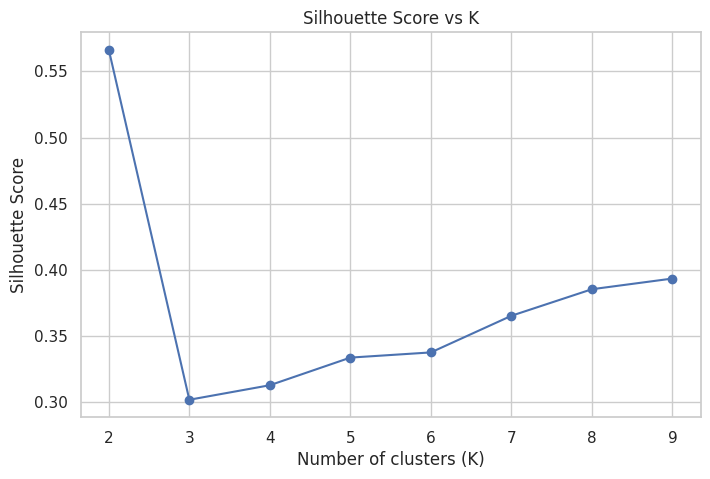

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [154]:
ks = range(2, 10)

inertias = []
silhouette_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, init = "k-means++", random_state=55, n_init=10
    )

    labels = kmeans.fit_predict(X_scaled)

    #elbow test
    inertias.append(kmeans.inertia_)

    #silhouette score
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method for K-Means++")
plt.savefig("images/elbow_method_content.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(list(ks), silhouette_scores, marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.savefig("images/silhouette_content.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/elbow_method_content.png")
files.download("images/silhouette_content.png")

The optimal number of clusters according to the silhouette score would be 2 but this is not informative enough, so taking into consideration the elbow-method plot, we have chosen **k=7**, with a silhouette score of **0.365** and an inertia of **30176**

In [128]:
k7 = list(ks).index(7)

inertia_k7 = inertias[k7]
silhouette_k7 = silhouette_scores[k7]

print("Inertia (k=7):", inertia_k7)
print("Silhouette (k=7):", silhouette_k7)

Inertia (k=7): 30176.37035266008
Silhouette (k=7): 0.36536293052936414


In [129]:
# Fitting K-Means++ model with k = 7
kmeans_ms = KMeans(n_clusters=7, init="k-means++", random_state=42, n_init=10)
label_ms = kmeans_ms.fit_predict(X_scaled)

# Attaching labels to movie_statistics dataframe (ms)
ms = ms.copy()
ms["cluster"]=label_ms

Explained variance ratio (PC1, PC2): [0.36299348 0.174205  ]
Total explained variance (2 PCs): 0.5371984768632523


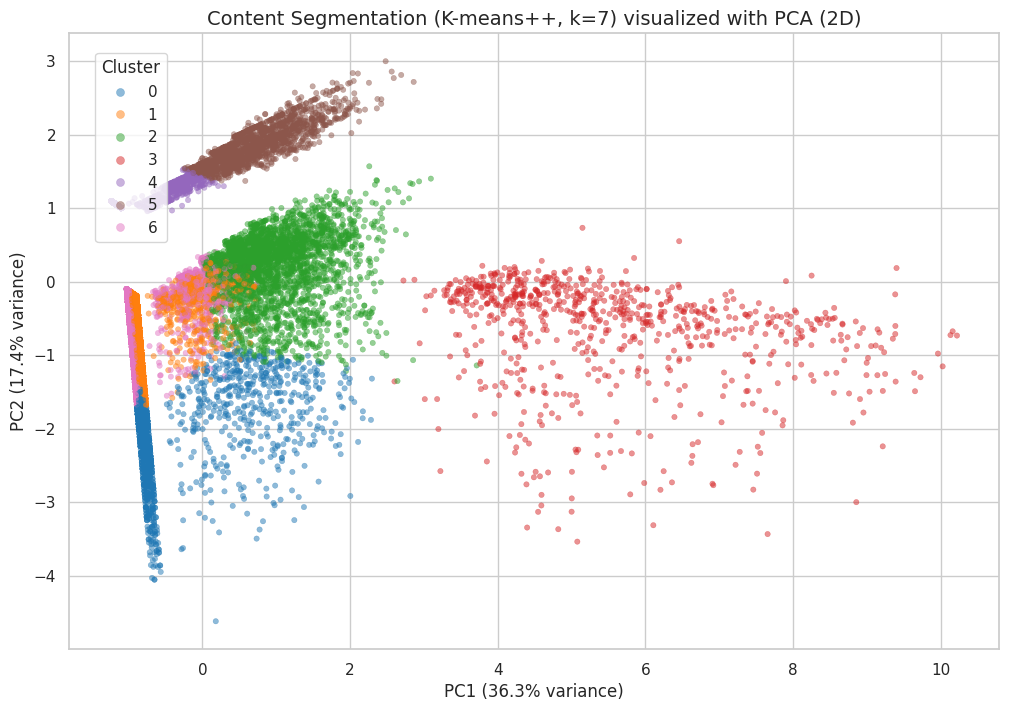

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
# Performing PCA in order to plot our clusters in a 2D space

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

ms["pc1"] = X_pca[:, 0]
ms["pc2"] = X_pca[:, 1]

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (2 PCs):", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(12, 8))

plot = sns.scatterplot(
    data=ms,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="tab10",
    s=15,
    alpha=0.5,
    edgecolor=None
)

plt.legend(
    title="Cluster",
    loc='upper left',
    bbox_to_anchor=(0.02, 0.98), # Fine-tune position inside the plot
    frameon=True,                # Adds the white box behind the legend
    markerscale=1.5              # Makes the circles in the legend easier to see
)

plt.title("Content Segmentation (K-means++, k=7) visualized with PCA (2D)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.savefig("images/content_cluster_pca.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/content_cluster_pca.png")



## Content Segmentation - Interpretation of clusters

🔵 **Cluster 0 – Vintage Niche Content (≈9%)**   
Oldest content with moderate ratings and low engagement. These are likely classic films that have a small but consistent footprint in the catalog. They do not generate modern "blockbuster" numbers but maintain a neutral reputation. This cluster has the oldest `mean_year_of_release` (1956.4) compared to the 1990s average of other clusters. The engagement is low (`mean_total_ratings` ≈ 0.88).

🟠 **Cluster 1 – High-Rated Obscure Gems (≈23%)**   
 Modern movies with high average ratings but minimal interaction. These titles represent a large portion of the catalog that few users have rated, but those who did liked them significantly. The near-zero variance suggests these might be "one-hit wonders" (movies with only 1 or 2 positive ratings). This group has the highest `mean_avg_rating` of any cluster, but a very low mean_std_rating (0.06). This combination typically indicates titles with very few ratings that happen to be 4 or 5 stars.

🟢 **Cluster 2 – Polarizing, Long-Lived Content (≈18%)**    
Content with average ratings but extreme disagreement among users. These movies are cases where users either love them or hate them. Despite the mixed reception, they sustain engagement over long periods. The `mean_std_rating` is the highest in the entire dataset (1.67), indicating massive disagreement. The `mean_activity_span_days` is also very high (1125 days), showing they stay relevant for years.

🔴 **Cluster 3 – The "Blockbusters" (≈5%)**   
They have massive engagement, high visibility, and widely discussed. This small elite group accounts for the vast majority of user activity. They are 1990s hits that everyone has seen, generating both high ratings and healthy debate The `mean_total_ratings` (6.73) is higher than all other clusters (which are mostly < 1.5). The `mean_unique_users` is similarly massive, confirming these are the "Popular" items driving the platform's traffic.

🟣 **Cluster 4 – Metadata-Poor "Ghosts" (≈18%)**   
 Neutral-rated content completely missing release years. These are likely catalog errors or minor titles that were ingested without proper metadata. They have low engagement and effectively zero rating variance. The `mean_year_missing` is 1.0, meaning 100% of these titles lack a release date. `mean_std_rating` is near zero, suggesting they are stagnant.

🟤 **Cluster 5 – Polarizing "Ghosts" (≈10%)**    
 Metadata-poor content that still generates disagreement. Unlike Cluster 4, these "ghost" titles (missing years) actually generate debate and activity. They might be cult classics or controversial titles where the metadata was simply lost or never entered. Like Cluster 4, the `mean_year_missing` is 1.0, but unlike Cluster 4, the `mean_std_rating` is very high (1.52), similar to the "Polarizing" Cluster 2.

⚫ **Cluster 6 – Low-Rated / Poor Quality (≈17%)**   
 Modern content with consistently bad ratings. These are the "flops" of the catalog. Users agree that these movies are poor, resulting in low ratings and low variance (consensus on bad quality). This cluster has the lowest `mean_avg_rating` (1.51). The low `mean_std_rating` (0.09) confirms that this isn't controversial—viewers universally dislike these titles.


In [131]:
# Feature list
features_ms = ["avg_rating", "std_rating", "total_ratings", "year_of_release", "unique_users", "activity_span_days", "year_missing"]

# Cluster sizes
cluster_sizes_ms = ms["cluster"].value_counts().sort_index()
cluster_shares_ms = (cluster_sizes_ms / cluster_sizes_ms.sum()).round(4)

# Means (easy to interpret)
cluster_means_ms = ms.groupby("cluster")[features_ms].mean()

# Medians (robust to skew)
cluster_medians_ms = ms.groupby("cluster")[features_ms].median()

# Combine into one table
segmentation = cluster_means_ms.add_prefix("mean_").join(
    cluster_medians_ms.add_prefix("median_")
)
segmentation["n_users"] = cluster_sizes_ms
segmentation["share_users"] = cluster_shares_ms

segmentation


mean_avg_rating  mean_std_rating  mean_total_ratings  \
cluster                                                         
0               2.988358         0.382612            0.878348   
1               4.065587         0.067733            0.765763   
2               3.024937         1.670650            1.246629   
3               3.205643         1.102312            6.735346   
4               2.993203         0.051966            0.751810   
5               2.977095         1.520614            1.233653   
6               1.507732         0.095817            0.779939   

         mean_year_of_release  mean_unique_users  mean_activity_span_days  \
cluster                                                                     
0                 1956.360584           0.878558               377.243066   
1                 1996.420382           0.766952                82.013016   
2                 1993.579774           1.245242              1124.944505   
3                 1990.403121           6.734568              1416.830949   
4                 1997.000000           0.752462                66.990113   
5                 1997.000000           1.230354              1265.324019   
6                 1995.831997           0.781508                97.566247   

         mean_year_missing  median_avg_rating  median_std_rating  \
cluster                                                            
0                      0.0           3.000000           0.000000   
1                      0.0           4.000000           0.000000   
2                      0.0           3.000000           1.527525   
3                      0.0           3.229167           1.091856   
4                      1.0           3.000000           0.000000   
5                      1.0           3.000000           1.414214   
6                      0.0           1.500000           0.000000   

         median_total_ratings  median_year_of_release  median_unique_users  \
cluster                                                                      
0                    0.693147                  1959.0             0.693147   
1                    0.693147                  1999.0             0.693147   
2                    1.098612                  1997.0             1.098612   
3                    6.304449                  1997.0             6.300786   
4                    0.693147                  1997.0             0.693147   
5                    1.098612                  1997.0             1.098612   
6                    0.693147                  1999.0             0.693147   

         median_activity_span_days  median_year_missing  n_users  share_users  
cluster                                                                        
0                              0.0                  0.0     1370       0.0887  
1                              0.0                  0.0     3611       0.2338  
2                           1020.0                  0.0     2739       0.1774  
3                           1393.0                  0.0      769       0.0498  
4                              0.0                  1.0     2832       0.1834  
5                           1237.0                  1.0     1503       0.0973  
6                              0.0                  0.0     2619       0.1696

# **INTERACTION ANALYSIS**
After having performed audience segmentation and content segmentation, we now perform interaction analysis to understand how different users interact with different types of content?
We aim to answer these questions:
1. Which content clusters are consumed by each audience segment? (Exposure matrix)
2. Which audience segments like which content clusters? (Preference matrix)
3. Where do users like content more than they are exposed to it, or vice versa? (Exposure vs Preference gap analysis)
4. Do the same audience segments interact with the same content clusters over time? (Temporal analysis)

In [132]:
# Reattaching IDs
# Recover user_cluster labels with customer_id
user_clusters = user_statistics_clean[["customer_id"]].reset_index(drop=True).copy()
user_clusters["user_cluster"] = us["cluster"].values

# Recover content_cluster labels with movie_id
movie_clusters = movie_statistics_clean[["movie_id"]].reset_index(drop=True).copy()
movie_clusters["content_cluster"] = ms["cluster"].values

# Sanity checks (alignment)
assert len(user_clusters) == len(us), "Row mismatch: user_statistics_clean vs us"
assert len(movie_clusters) == len(ms), "Row mismatch: movie_statistics_clean vs ms"

print("User clusters rows:", user_clusters.shape)
print("Movie clusters rows:", movie_clusters.shape)

User clusters rows: (435769, 2)
Movie clusters rows: (15443, 2)


In [133]:
vr_int = vr.merge(
    user_clusters,
    on="customer_id",
    how="left"
).merge(
    movie_clusters,
    on="movie_id",
    how="left"
)

In [134]:
vr_int["date"] = pd.to_datetime(vr_int["date"], errors="coerce")

# Drop rows that can't be used for interaction/temporal analysis
vr_int = vr_int.dropna(subset=["user_cluster", "content_cluster", "rating", "date"])

# Make clusters ints (helps with indexing/plots)
vr_int["user_cluster"] = vr_int["user_cluster"].astype(int)
vr_int["content_cluster"] = vr_int["content_cluster"].astype(int)

print("Interactions after merge/dropna:", vr_int.shape)
print("Missing user_cluster:", vr_int["user_cluster"].isna().sum())
print("Missing content_cluster:", vr_int["content_cluster"].isna().sum())

Interactions after merge/dropna: (3621090, 6)
Missing user_cluster: 0
Missing content_cluster: 0


## Exposure matrix
This exposure heatmap aims to show how user attention is distributed across different types of content, it can help us to detect concentration effects where there is one content cluster that dominates the exposure of all clusters of users.

The exposure heatmap reveals an strong concentration of user interactions around the "Blockbusters" content cluster, confirming a severe popularity bias in the current system. Across all user segments, especially Active Exploratory Users and Positive Regulars where exposure reaches nearly 100%, the majority of interactions are directed toward these mainstream titles, while potentially valuable clusters like "Hidden Gems," "Vintage Niche," and "Ghost Titles" receive negligible exposure. This suggests that consumption is driven almost entirely by aggregate popularity rather than personalized preference, effectively rendering most of the catalog invisible.

These results should motivate the use of recommendation systems to change exposure and better match user preferences.


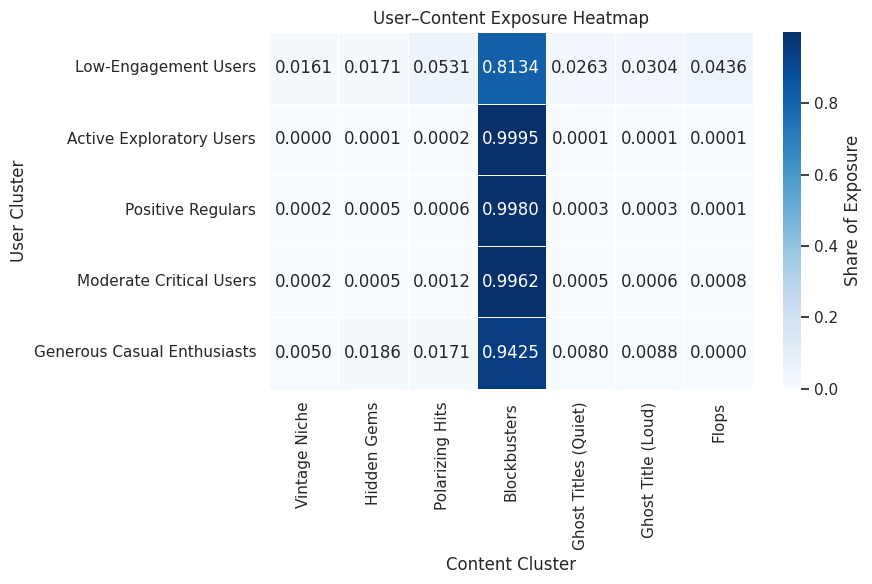

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [136]:
user_cluster_labels = {
    0: "Low-Engagement Users",
    1: "Active Exploratory Users",
    2: "Positive Regulars",
    3: "Moderate Critical Users",
    4: "Generous Casual Enthusiasts"
}


content_cluster_labels = {
    0: "Vintage Niche",
    1: "Hidden Gems",
    2: "Polarizing Hits",
    3: "Blockbusters",
    4: "Ghost Titles (Quiet)",
    5: "Ghost Title (Loud)",
    6: "Flops"
}

# Raw counts of interactions
exposure_matrix = (
    vr_int
    .groupby(["user_cluster", "content_cluster"])
    .size()
    .unstack(fill_value=0)
)

# Row-normalized shares (each row sums to 1)
exposure_share = exposure_matrix.div(exposure_matrix.sum(axis=1), axis=0)

# Replace numeric labels with names
exposure_share_named = exposure_share.copy()
exposure_share_named.index = exposure_share_named.index.map(user_cluster_labels)
exposure_share_named.columns = exposure_share_named.columns.map(content_cluster_labels)

plt.figure(figsize=(9, 6))
sns.heatmap(
    exposure_share_named,
    annot=True,
    fmt=".4f",
    cmap="Blues",
    cbar_kws={"label": "Share of Exposure"},
    linewidths=0.5
)

plt.xlabel("Content Cluster")
plt.ylabel("User Cluster")
plt.title("User–Content Exposure Heatmap")

plt.tight_layout()
plt.savefig("images/exposure_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/exposure_heatmap.png")


## Preference matrix
The preference matrix summarizes how different user segments rate different types of content by reporting the average rating given by each user cluster to each content cluster. Unlike exposure-based analyses, this matrix captures true signals of what users prefer when they interact with content.


The User–Content Preference Heatmap reveals heterogeneity in user tastes, highlighting clear opportunities for personalized matching beyond just using aggregate popularity:
- Low-Engagement Users consistently assign the lowest ratings across nearly all content types, indicating weak preference signals and suggesting they may benefit from safe, mainstream recommendations to increase retention. In contrast, Generous Casual Enthusiasts rate almost all content highly, reflecting strong enthusiasm and high suitability for exploratory and long-tail recommendations.

- Hidden Gems receive the most consistently high ratings across all active user segments, identifying them as high-quality content that remains under leveraged by the system. While Blockbusters perform reliably among Positive Regulars and Active Exploratory Users, they are viewed more critically by Moderate Critical Users, confirming that even mainstream content is subject to segment specific critique.

- Vintage Niche, Polarizing Hits, and both Ghost Title clusters perform well among Generous Casual Enthusiasts and Positive Regulars, indicating significant hidden value in these categories when surfaced to the right audience despite their limited broad appeal. Conversely, Flops are universally rejected across all segments, with ratings often falling below 2.0, reinforcing their status as low-quality content that should be filtered.




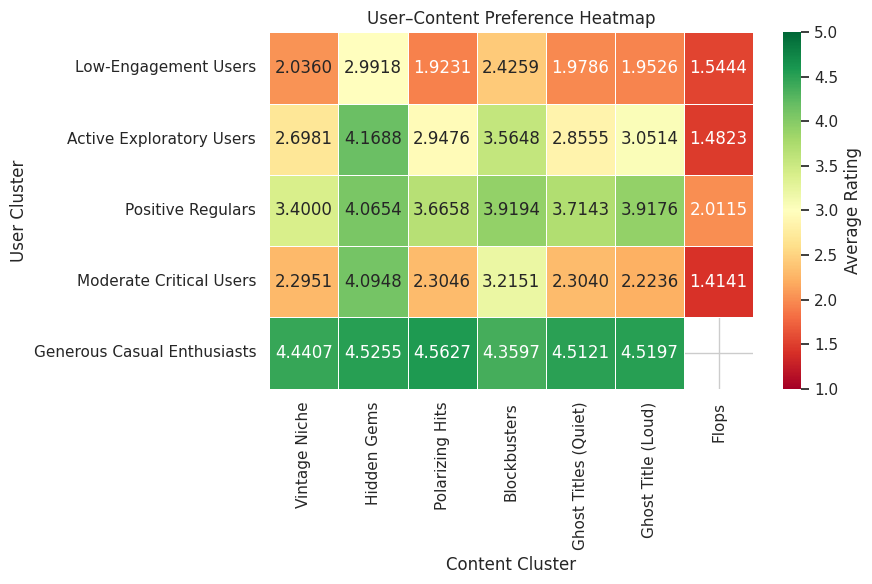

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [138]:
preference_matrix = (
    vr_int
    .groupby(["user_cluster", "content_cluster"])["rating"]
    .mean()
    .unstack()
)

# Replace numeric cluster IDs with descriptive labels
preference_matrix_named = preference_matrix.copy()
preference_matrix_named.index = preference_matrix_named.index.map(user_cluster_labels)
preference_matrix_named.columns = preference_matrix_named.columns.map(content_cluster_labels)

plt.figure(figsize=(9, 6))
sns.heatmap(
    preference_matrix_named,
    annot=True,
    fmt=".4f",
    cmap="RdYlGn",
    vmin=1, vmax=5,
    cbar_kws={"label": "Average Rating"},
    linewidths=0.5
)

plt.xlabel("Content Cluster")
plt.ylabel("User Cluster")
plt.title("User–Content Preference Heatmap")

plt.tight_layout()
plt.savefig("images/preference_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/preference_heatmap.png")


## Preference-Exposure Gap analysis
The aim of this analysis is to be able to answer the question:

> Where is content liked more than it is consumed (under-exposed)
and where is content consumed more than it is liked (over-exposed)?

So we can use this information in order to improve our recommendation strategies.

**Interpretation of the gap analysis:**
- Positive values (orange/red): signify opportunities, which are areas where users give higher than average ratings to content that they aren't seeing very much.
- Negative values (blue): signify oversaturation/issues, these are areas where users are interacting with content frequently but giving it low ratings. Meaning they are likely being forced to engage with content they don't really enjoy (or they are just naturally unhappy with everything they watch).
- Near zero (white): equilibrium, the exposure matches the preference perfectly.


**Strategic findings:**
1. Almost all active user archetypes show significant positive gaps for "Hidden Gems", suggesting these high-quality titles are being suppressed by the current system and should be prioritized in recommendations.

2. Low-Engagement segment shows extreme negative gaps across almost all content clusters, indicating they are being "forced" to engage with content they consistently dislike, which is a major driver for potential platform abandonment.

3. Most highly active groups, such as Moderate Critical Users and Active Exploratory Users, show negative gaps for "Blockbusters," confirming that while these titles are pushed heavily, the actual user satisfaction does not justify the current level of dominant exposure.

4. Positive Regulars and Generous Casual Enthusiasts show strong positive gaps for "Ghost Titles," "Polarizing Hits," and "Vintage Niche," representing massive untapped opportunities to diversify their feeds with specialized content they are likely to appreciate.


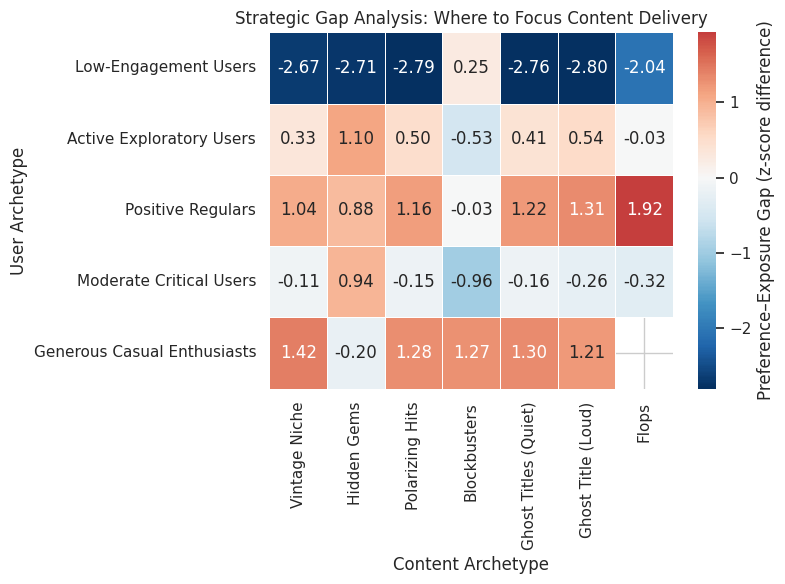

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
# Because exposure_matrix and preference_matrix are on different scales we standardize them to compare patterns

def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sigma = df.std(axis=0).replace(0, np.nan)
    return (df - mu) / sigma

exposure_z = zscore_cols(exposure_share)
preference_z = zscore_cols(preference_matrix)
pref_exposure_gap = preference_z - exposure_z

pref_exposure_gap_named = pref_exposure_gap.copy()
pref_exposure_gap_named.index = pref_exposure_gap_named.index.map(user_cluster_labels)
pref_exposure_gap_named.columns = pref_exposure_gap_named.columns.map(content_cluster_labels)

plt.figure(figsize=(8, 6))

sns.heatmap(
    pref_exposure_gap_named,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",           # Diverging: Red (negative) to Blue (positive)
    center=0,                # 0 = Equilibrium
    linewidths=0.5,
    cbar_kws={"label": "Preference–Exposure Gap (z-score difference)"}
)

plt.xlabel("Content Archetype")
plt.ylabel("User Archetype")
plt.title("Strategic Gap Analysis: Where to Focus Content Delivery")

plt.tight_layout()
plt.savefig("images/gap_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/gap_analysis.png")

## Continuation of Gap Analysis
This analysis identifies strategic "missed opportunities" where high-quality content is hidden from interested users, and "saturation issues" where users are repeatedly shown content they consistently dislike.


**Actionable Insights:**
- Cluster 4 (Generous Casual Enthusiasts) – these users are massively underserved across almost every niche, showing big positive gaps for Vintage Niche, Ghost Titles, and Blockbusters.
  - Action to take: Since they are "easy to please," use this segment to boost engagement across the entire catalog, particularly by surfacing high-quality but under-exposed titles.

- Cluster 2 (Positive Regulars) – this group has the highest appetite for Flops and Ghost Titles, suggesting they find value in content that others reject.
  - Action to take: Direct "problem" content, like metadata-poor titles or low-rated new releases to this group first. Their feedback can help the algorithm decide if a title is truly a "flop" or just a niche "hidden gem."

- Cluster 0 (Low-Engagement Users) – these users are in a "negative feedback loop," specifically regarding Polarizing Hits and Ghost Titles.
  - Action to take: Stop experimenting on these users with niche content. Immediately pivot their feed to blockbusters or universally loved movies to prevent them from exiting the platform.

- Clusters 1 & 3 (Active & Critical Viewers) – both the Active Exploratory Users and Moderate Critical Users show negative gaps for Blockbusters, meaning the "Top 10" hits are being over-promoted to them.
  - Action to take: Transition these users away from generic popularity based movies and toward Hidden Gems, which is the only category they both show a strong positive preference for.


In [140]:
# Top opportunities / issues
gap_long = pref_exposure_gap.stack().sort_values(ascending=False)

print("\nTop under-exposed but liked (opportunities):")
print(gap_long.head(10))

print("\nTop over-exposed but disliked (issues):")
print(gap_long.tail(10))


Top under-exposed but liked (opportunities):
user_cluster  content_cluster
2             6                  1.923373
4             0                  1.419179
2             5                  1.313904
4             4                  1.297193
              2                  1.279477
              3                  1.268349
2             4                  1.215139
4             5                  1.210209
2             2                  1.159404
1             1                  1.102181
dtype: float64

Top over-exposed but disliked (issues):
user_cluster  content_cluster
3             5                 -0.264546
              6                 -0.315034
1             3                 -0.527574
3             3                 -0.962375
0             6                 -2.042263
              0                 -2.674353
              1                 -2.713158
              4                 -2.760991
              2                 -2.790197
              5                 -2.79723

# Temporal analysis
One way to answer the question whether the same audience segments interact with the same content clusters as the platform evolves from a growing platform to a saturated one, is to understand whether audience-content relationships are stable or evolving is to compare interaction patterns in an early-period vs late-period.

Due to the massive surge in participants in 2005, if we were to split into an early and late period based on time, the results might be skewed by the few people who interacted with this platform in its early period. Therefore we are splitting by volume instead of time.
However, we do acknowledge that the establishment period lasts much longer thanthe high-growth period (which essentially only covers 2005).

Through this analysis we can identify whether specific audience segments are fundamentally shifting their consumption habits (Exposure) or their satisfaction levels (Preference).

1. **Evolution of Exposure Share over time** - this plot identifies where content clusters are gaining or losing "market share" within each user group.
    - The most significant shift is seen in Low-Engagement Users, who show a big increase in exposure to Blockbusters, indicating a system wide shift toward aggressive mainstreaming.
    - Almost all groups show a decrease in their exposure to Vintage Niche, Hidden Gems, and Polarizing Hits over time, with Generous Casual Enthusiasts seeing a drop in Blockbuster exposure share compared to other groups.
    - The platform's behavior trended heavily toward "safe," popular content as the dataset progressed, often at the expense of niche or metadata-poor catalog titles, which saw nearly declines in exposure across segments.

2. **Evolution of User Preference** - this plot reveals shifts in sentiment, showing if users are becoming more or less satisfied with specific content archetypes:
    - Moderate Critical Users show a significant increase in their rating of Polarizing Hits. This suggests that our most critical users are developing more refined tastes as they interact more with the platform.
    - While exposure to Blockbusters increased significantly for segments like Low-Engagement Users, user preference for it remained largely stagnant or saw only negligible growth.
    - Moderate Critical Users show a severe drop in preference for Vintage Niche. This may indicate that as these selective users exhaust the high-quality legacy titles, they are left with lower-quality older content that they rate much more poorly.


Median year split: 2005-01-09 00:00:00
Early interactions: 1807393
Late interactions: 1813697


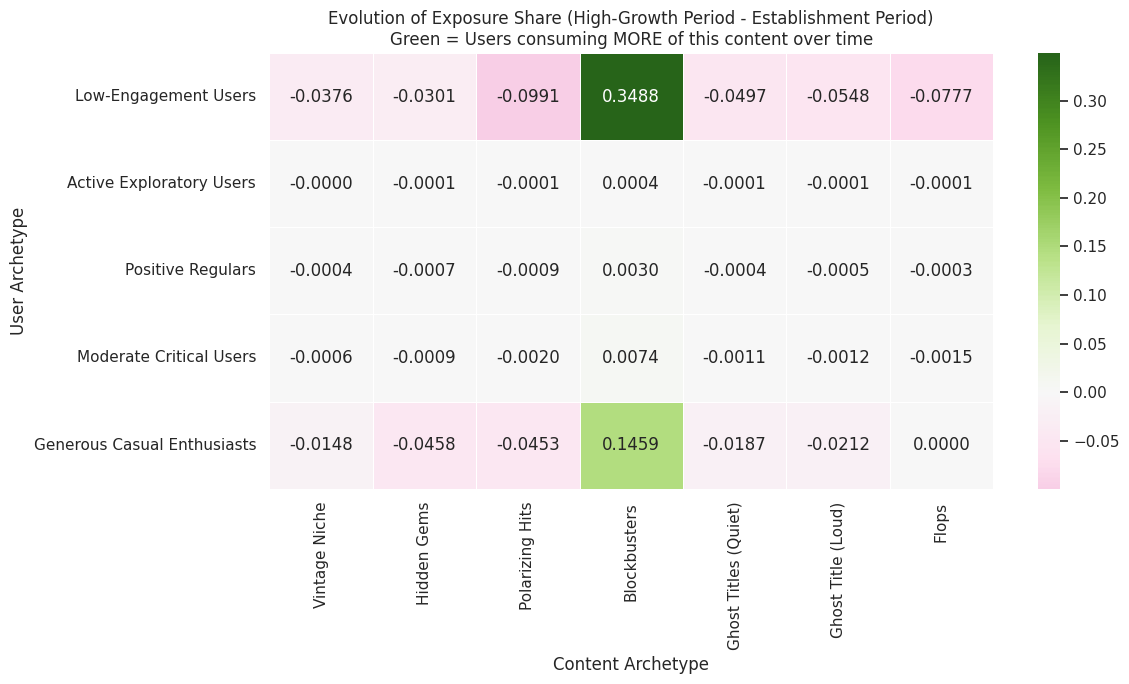

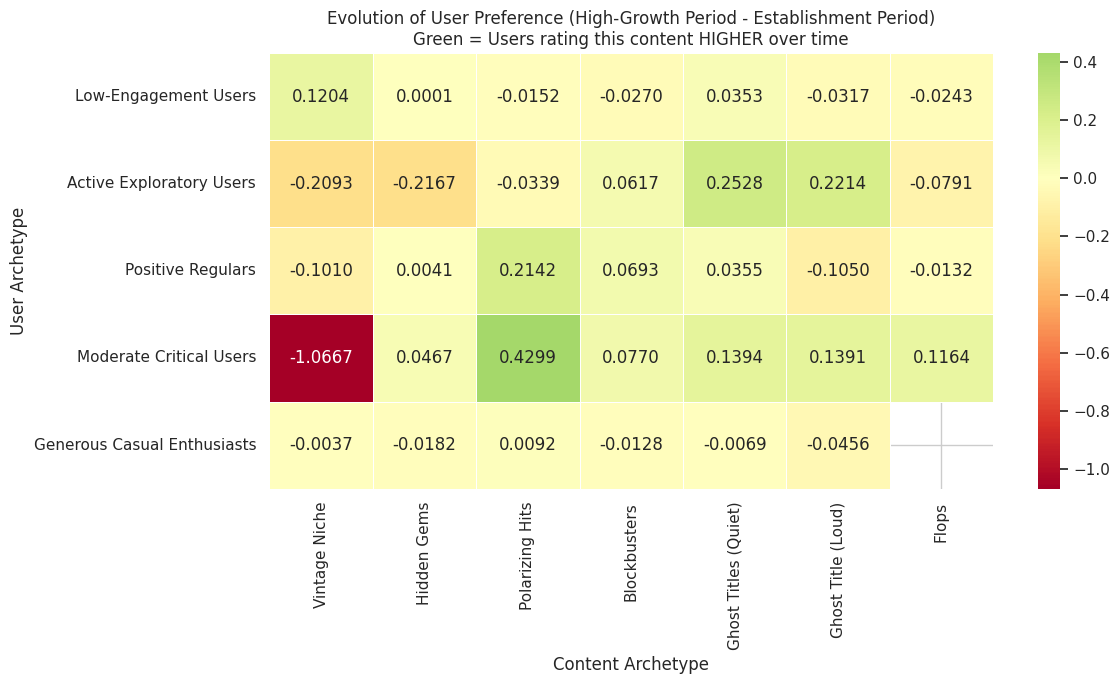


--- Stability Check (Mean Absolute Change) ---
Exposure Share Stability: 0.02888951232935271
Preference Stability: 0.11546139647432778


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
# Splitting interaction period in 2 based on the median
median_timestamp = vr_int["date"].median()

early = vr_int[vr_int["date"] < median_timestamp].copy()
late  = vr_int[vr_int["date"] >= median_timestamp].copy()

print("\nMedian year split:", median_timestamp)
print("Early interactions:", early.shape[0])
print("Late interactions:", late.shape[0])

# 3. Matrix Building Function
def build_matrices(df: pd.DataFrame):
    # Exposure: How much each user cluster interacts with each content cluster
    exp = df.groupby(["user_cluster", "content_cluster"]).size().unstack(fill_value=0)
    # Row-normalize to get shares (proportions)
    exp_share = exp.div(exp.sum(axis=1), axis=0)
    # Preference: Average rating per user/content cluster intersection
    pref = df.groupby(["user_cluster", "content_cluster"])["rating"].mean().unstack()
    return exp_share, pref

# Compute for both periods
early_share, early_pref = build_matrices(early)
late_share,  late_pref  = build_matrices(late)

# 4. Alignment & Labeling
# Aligning to the main exposure_share/preference_matrix ensures no missing categories
early_share = early_share.reindex_like(exposure_share).fillna(0)
late_share  = late_share.reindex_like(exposure_share).fillna(0)
early_pref  = early_pref.reindex_like(preference_matrix)
late_pref   = late_pref.reindex_like(preference_matrix)

# Map labels to the index and columns
for df in [early_share, late_share, early_pref, late_pref]:
    df.index = df.index.map(user_cluster_labels)
    df.columns = df.columns.map(content_cluster_labels)

# 5. Computing Temporal changes
# Positive = Increase over time | Negative = Decrease over time
delta_exposure_share = late_share - early_share
delta_preference = late_pref - early_pref

# 6. Visualization: Consumption Evolution
plt.figure(figsize=(12, 7))
sns.heatmap(
    delta_exposure_share,
    annot=True,
    fmt=".4f",
    cmap="PiYG", # Pink-Green diverging map: Green is growth, Pink is decline
    center=0,
    linewidths=0.5
)
plt.title("Evolution of Exposure Share (High-Growth Period - Establishment Period)\nGreen = Users consuming MORE of this content over time")
plt.xlabel("Content Archetype")
plt.ylabel("User Archetype")
plt.tight_layout()
plt.savefig("images/evolution_exposure_share.png", dpi=300, bbox_inches="tight")
plt.show()

# 7. Visualization: Preference Evolution
plt.figure(figsize=(12, 7))
sns.heatmap(
    delta_preference,
    annot=True,
    fmt=".4f",
    cmap="RdYlGn", # Red-Yellow-Green: Green is liking more, Red is liking less
    center=0,
    linewidths=0.5
)
plt.title("Evolution of User Preference (High-Growth Period - Establishment Period)\nGreen = Users rating this content HIGHER over time")
plt.xlabel("Content Archetype")
plt.ylabel("User Archetype")
plt.tight_layout()
plt.savefig("images/evolution_user_preference.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary Statistic for Stability
print("\n--- Stability Check (Mean Absolute Change) ---")
print("Exposure Share Stability:", delta_exposure_share.abs().mean().mean())
print("Preference Stability:", delta_preference.abs().mean().mean())

files.download("images/evolution_exposure_share.png")
files.download("images/evolution_user_preference.png")

The below statistics can be translated into the following insights:
- The platform transitioned into a hit-driven model over time, with Low-Engagement Users seeing a massive increase in exposure to Blockbusters
- As mainstream hits took over, niche categories were pushed out; Low-Engagement Users saw the largest drops in exposure to Polarizing Hits and Flops
- Even Generous Casual Enthusiasts were funneled toward hits, with their exposure to Blockbusters rising while their access to Hidden Gems and Polarizing Hits fell
- Highly Active and Selective Viewers (Active Exploratory and Moderate Critical users) showed almost zero change in their exposure patterns, with shifts often less than 0.01, suggesting these users have fixed habits or search patterns that remain resilient to algorithmic trends
- The data indicates that the recommendation engine shifted toward "safe" bets over time, likely in an attempt to spark activity in disengaged users by aggressively promoting the most popular content.

In [142]:
# Identifying meaningful shifts
print("\nLargest increases in exposure share (late - early):")
print(delta_exposure_share.stack().sort_values(ascending=False).head(10))

print("\nLargest decreases in exposure share (late - early):")
print(delta_exposure_share.stack().sort_values().head(10))


Largest increases in exposure share (late - early):
user_cluster                 content_cluster     
Low-Engagement Users         Blockbusters            0.348815
Generous Casual Enthusiasts  Blockbusters            0.145934
Moderate Critical Users      Blockbusters            0.007391
Positive Regulars            Blockbusters            0.003038
Active Exploratory Users     Blockbusters            0.000389
Generous Casual Enthusiasts  Flops                   0.000000
Active Exploratory Users     Vintage Niche          -0.000045
                             Flops                  -0.000062
                             Polarizing Hits        -0.000064
                             Ghost Titles (Quiet)   -0.000067
dtype: float64

Largest decreases in exposure share (late - early):
user_cluster                 content_cluster     
Low-Engagement Users         Polarizing Hits        -0.099050
                             Flops                  -0.077664
                             Ghost 

While the platform successfully funneled users, especially Low-Engagement Users, toward Blockbusters, those users actually liked that content less as time went on, with ratings dropping. This suggests that aggressively pushing popular movies is an insufficient strategy to fix low engagement.

In contrast, Moderate Critical Users and Active Exploratory Users are rating Polarizing Hits and Ghost Titles much higher than they used to. These power users seem to be "leveling up" their tastes, becoming the primary audience for difficult, niche, or metadata-poor content.

There is a severe preference drop for Vintage Niche content across the board, most notably among Moderate Critical Users and Active Exploratory Users. This implies that once users exhaust the high-quality "classics" in the legacy cluster, the remaining titles fail to hold their interest, leading to sharp declines in satisfaction.

In [143]:
# Preference drift - if tastes change
print("\nLargest increases in avg rating (late - early):")
print(delta_preference.stack().sort_values(ascending=False).head(10))

print("\nLargest decreases in avg rating (late - early):")
print(delta_preference.stack().sort_values().head(10))


Largest increases in avg rating (late - early):
user_cluster              content_cluster     
Moderate Critical Users   Polarizing Hits         0.429902
Active Exploratory Users  Ghost Titles (Quiet)    0.252795
                          Ghost Title (Loud)      0.221429
Positive Regulars         Polarizing Hits         0.214161
Moderate Critical Users   Ghost Titles (Quiet)    0.139439
                          Ghost Title (Loud)      0.139141
Low-Engagement Users      Vintage Niche           0.120449
Moderate Critical Users   Flops                   0.116438
                          Blockbusters            0.077011
Positive Regulars         Blockbusters            0.069336
dtype: float64

Largest decreases in avg rating (late - early):
user_cluster                 content_cluster   
Moderate Critical Users      Vintage Niche        -1.066667
Active Exploratory Users     Hidden Gems          -0.216667
                             Vintage Niche        -0.209316
Positive Regulars     

# **PREDICTING INDIVIDUAL RATINGS**
As part of our project, we were asked to predict individual ratings, we will do so using 4 different techniques:
1. Linear Regression
2. Artificial-Neural-Network (ANN)
3. Decision tree
4. Random Forest

### Data Assembly phase

We take our separate data sources and stitch them together into a single "Master Table" that the machine learning model can actually read and to do this we:

1. Create `df_lr` (DataFrame for Linear Regression) by combining four different tables.
We start with `viewer_ratings_clean` (individual ratings) in which every row is one specific interaction and, then, we attach:
- extra information to each rating without losing any original rows,
- `user_statistics` so the model knows who the rater is (e.g., "This user is active," "This user usually rates low"),
- `movie_statistics` so the model knows what is being rated (e.g., "This movie is popular"),
- `movies` (mv) to get the year_of_release.

2. Explicitly define the features the model is allowed to study and we get as a result "X": this variable contains only the input data for the model.

3. Clean & do Target Separation (y).
- ML models generally crash if they encounter a "Not a Number" (NaN), so X = X. Therefore we drop all rows containing a Nan.
- With y = df_lr["rating"] we isolate the target so that the model will try to use the data in X to guess the number in y.

In [63]:
# 1) Merge everything into one table (one row per rating)
df_lr = (
    viewer_ratings_clean
    .merge(user_statistics_clean, on="customer_id", how="left", suffixes=("", "_user"))
    .merge(movie_statistics_clean, on="movie_id", how="left", suffixes=("", "_movie"))
    .merge(
        mv[["movie_id", "year_of_release"]],
        on="movie_id",
        how="left",
        suffixes=("", "_meta")
    )
)

# 2) Generate a 10% User-Based Sample
# Set seed for reproducability (so we get the same kind of users every time)
np.random.seed(55)

# Get list of unique users
all_users = df_lr['customer_id'].unique()

# Pick 10% of users randomly
sampled_users = np.random.choice(all_users, size=int(len(all_users) * 0.10), replace=False)

# Filter the dataframe to keep ONLY these users
print(f"Original rows: {len(df_lr)}")
df_lr = df_lr[df_lr['customer_id'].isin(sampled_users)]
print(f"Rows after user sampling: {len(df_lr)}")

# 3) Define Predictors and Clean Data (Drop NaNs)
feature_cols = [
    "total_ratings", "std_rating", "avg_rating",
    "unique_movies", "activity_days",
    "total_ratings_movie", "std_rating_movie", "avg_rating_movie", "unique_users",
    "year_of_release", "year_missing"
]

# Dropping rows where features, target (rating), or date are NaN
df_lr = df_lr.dropna(subset=feature_cols + ["rating", "date"])
print(f"Rows after dropping NaNs: {len(df_lr)}")

Original rows: 3621739
Rows after user sampling: 365885
Rows after dropping NaNs: 365821


We implemented a Time-Based Split, which sorts our data chronologically to simulate real-world forecasting.

By training on the oldest 70% of interactions and testing on the newest 15%, you ensure the model learns strictly from the "past" to predict the "future," preventing it from cheating by seeing data from later dates.

In [64]:
# 4) Temporal Preparation: Sort by Date
df_lr = df_lr.sort_values("date").reset_index(drop=True)

X = df_lr[feature_cols]
y = df_lr["rating"]

# 5) Temporal Split (70% Train, 15% Val, 15% Test)
n = len(df_lr)
e1 = int(0.70 * n)
e2 = int(0.85 * n)

# 6) Slice the Data (Time-Based Split)
X_train_lr, X_val_lr, X_test_lr = X.iloc[:e1], X.iloc[e1:e2], X.iloc[e2:]
y_train_lr, y_val_lr, y_test_lr = y.iloc[:e1], y.iloc[e1:e2], y.iloc[e2:]

## Standardizing features and possible Data leakage


We standardized the features (sc = StandardScaler():) to fix the "Unit Problem": year column has huge numbers (e.g., 2023), while quality has tiny numbers (e.g., 4.5), this means that without scaling, the model might think year is 500x more important just because the number is bigger, so we force all features to have a mean of 0 and a variance of 1.

To do this we use:
- `fit_transform(X_train_s_lr)`: calculates the mean and math from the Training data and scales it.

- `transform(X_val_s_lr / X_test_s_lr)`: takes the math rules learned from the Training set and applies them to the Test set (mean for the test set is not recomputed preventing "Data Leakage", cheating by letting the model know statistics about the test data).

In [65]:
# 7) Scale (Learn from Train, Apply to Val/Test)
sc = StandardScaler()
X_train_s_lr = sc.fit_transform(X_train_lr)
X_val_s_lr   = sc.transform(X_val_lr)
X_test_s_lr  = sc.transform(X_test_lr)

# --- Final Output Verification ---
print("-" * 30)
print(f"X_train shape: {X_train_s_lr.shape} | y_train shape: {y_train_lr.shape}")
print(f"X_val shape:   {X_val_s_lr.shape}   | y_val shape:   {y_val_lr.shape}")
print(f"X_test shape:  {X_test_s_lr.shape}  | y_test shape:  {y_test_lr.shape}")
print(f"Train date range: {df_lr.iloc[0]['date']} to {df_lr.iloc[e1-1]['date']}")
print("Preprocessing Complete. Ready for Models.")

------------------------------
X_train shape: (256074, 11) | y_train shape: (256074,)
X_val shape:   (54873, 11)   | y_val shape:   (54873,)
X_test shape:  (54874, 11)  | y_test shape:  (54874,)
Train date range: 1995-01-08 00:00:00 to 2005-06-02 00:00:00
Preprocessing Complete. Ready for Models.


In [66]:
print("Train target distribution:")
print(y_train_lr.value_counts(normalize=True))

print("\nValidation target distribution:")
print(y_val_lr.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test_lr.value_counts(normalize=True))

Train target distribution:
rating
4.0    0.352558
3.0    0.287198
5.0    0.215922
2.0    0.100198
1.0    0.044124
Name: proportion, dtype: float64

Validation target distribution:
rating
4.0    0.332732
3.0    0.279099
5.0    0.252620
2.0    0.089607
1.0    0.045942
Name: proportion, dtype: float64

Test target distribution:
rating
4.0    0.335787
3.0    0.269508
5.0    0.260087
2.0    0.088184
1.0    0.046434
Name: proportion, dtype: float64


## **Linear Regresssion**

Linear Regression is the fundamental starting point for predictive modeling because it assumes the simplest possible relationship, a **straight line**, between our inputs and the target.
By deploying it first, we establish a "sanity check" baseline; if our advanced methods cannot significantly outperform this simple linear model, it suggests the data itself is noisy rather than the model being too simple.

Additionally, unlike "black box" deep learning models, Linear Regression provides **immediate interpretability**, which directly addresses the project's requirement to derive explainable insights rather than just raw predictions.

In [44]:
# Training linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_s_lr, y_train_lr)


LinearRegression()

####Testing how well our baseline model predicts ratings

After generating predictions (.predict) by taking the input features (Year, Popularity, etc.) and using its learned formula to generate a "guessed" rating for every single row, we calculate the Scorecard (the metrics):
 - $R^2$ = measures "How much of the pattern did we capture?" (closer to 1.0 is better; 0.045 is your baseline).
 - $RMSE$ (Root Mean Squared Error) = measures "How far off are we on average?" and it penalizes big mistakes heavily.
 - $MAE$ (Mean Absolute Error) = measures "What is the average error?" (e.g., if $MAE$ is 1.2, your prediction is usually 1.2 stars away from the real rating).

We repeat this process for three separate groups to diagnose the overall model health:
- Train Metrics = Did the model learn anything? (if this is bad, the model is "Underfitting").
- Validation Metrics = How well does it generalize? (used to tune settings before the final test).
- Test Metrics = The final "Exam" (if Train is good but Test is bad, the model is "Overfitting")

The output confirms our model is robust and statistically healthy, as the scores are consistent across all three datasets (Train, Validation, Test), proving it is not overfitting: while an $R^2$ of 0.36 means you only capture about one-third of the complex reasons behind user ratings, the $MAE$ of 0.68 indicates your predictions are reliable enough to be less than one star off on average.

Effectively, the model successfully identifies general behavioral trends but lacks the granular data needed to predict exact ratings with high precision.

In [45]:
y_pred_train_lr = lin_reg.predict(X_train_s_lr)

r2 = r2_score(y_train_lr, y_pred_train_lr)
rmse = np.sqrt(mean_squared_error(y_train_lr, y_pred_train_lr))
mae = mean_absolute_error(y_train_lr, y_pred_train_lr)

print(f"\n--- Train Metrics ---")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


y_pred_val_lr = lin_reg.predict(X_val_s_lr)

r2_val = r2_score(y_val_lr, y_pred_val_lr)
rmse_val = np.sqrt(mean_squared_error(y_val_lr, y_pred_val_lr))
mae_val = mean_absolute_error(y_val_lr, y_pred_val_lr)

print("\n--- Validation Metrics ---")
print(f"R-Squared: {r2_val:.4f}")
print(f"RMSE:      {rmse_val:.4f}")
print(f"MAE:       {mae_val:.4f}")


# --- Final evaluate on test ---
y_pred_test_lr = lin_reg.predict(X_test_s_lr)

r2_test = r2_score(y_test_lr, y_pred_test_lr)
rmse_test = np.sqrt(mean_squared_error(y_test_lr, y_pred_test_lr))
mae_test = mean_absolute_error(y_test_lr, y_pred_test_lr)

print("\n--- Test Metrics ---")
print(f"R-Squared: {r2_test:.4f}")
print(f"RMSE:      {rmse_test:.4f}")
print(f"MAE:       {mae_test:.4f}")


--- Train Metrics ---
R²:   0.3266
RMSE: 0.8753
MAE:  0.6867

--- Validation Metrics ---
R-Squared: 0.3549
RMSE:      0.8746
MAE:       0.6786

--- Test Metrics ---
R-Squared: 0.3604
RMSE:      0.8741
MAE:       0.6805


# Data Leakage Issue
As shown in the code above, due to using predictors such as `avg_rating` and `total_ratings` when predicting individual ratings, there is a data leakage issue which bloat the metrics, making them seem larger than what they actually are. Therefore below we have adopted a data leakage safe method that builds features based on past data, before the rating was computed.
It uses cumulative sums and counts, then shifts them by one row. This ensures that the model only sees what happened before the current rating, not the rating itself. It then calculates how active a user has been, their average score, and how popular or well-rated a movie was up until that specific moment.
For ratings made in the very beginning, because there is no past data, it is imputed with the median.

User-based sampling is also implemented here to reduce runtime.

In [144]:
# 1) User-based sampling
# This ensures we keep the full history of 10% of users
np.random.seed(42)
all_users = viewer_ratings_clean['customer_id'].unique()
sampled_users = np.random.choice(all_users, size=int(len(all_users) * 0.10), replace=False)

# Filter the original dataframe to create our working sample
df_sampled = viewer_ratings_clean[viewer_ratings_clean['customer_id'].isin(sampled_users)].copy()
print(f"Sampled Dataset: {df_sampled.shape[0]} interactions from {len(sampled_users)} users.")

# 2) Leakage free feature engineering function
def build_past_only_features(vr: pd.DataFrame) -> pd.DataFrame:
    df = vr.copy()

    # Sort chronologically to ensure cumsum/cumcount represent the past
    df = df.sort_values(["date", "customer_id", "movie_id"]).reset_index(drop=True)

    # USER past only aggregates
    ug = df.groupby("customer_id", sort=False)
    df["user_total_ratings_past"] = ug.cumcount()
    df["rating_sq"] = df["rating"] ** 2

    # Shift cumulative results so current row doesn't 'see' itself
    user_sum_cum = ug["rating"].cumsum()
    user_sumsq_cum = ug["rating_sq"].cumsum()
    df["user_sum_rating_past"] = user_sum_cum - df["rating"]
    df["user_sumsq_rating_past"] = user_sumsq_cum - df["rating_sq"]

    df["user_avg_rating_past"] = df["user_sum_rating_past"] / df["user_total_ratings_past"].replace(0, np.nan)

    n = df["user_total_ratings_past"]
    var = (df["user_sumsq_rating_past"] - (df["user_sum_rating_past"] ** 2) / n.replace(0, np.nan)) / (n - 1).replace(0, np.nan)
    df["user_std_rating_past"] = np.sqrt(var.where(n >= 2))

    df["user_min_rating_past"] = ug["rating"].transform(lambda s: s.cummin().shift(1))
    df["user_max_rating_past"] = ug["rating"].transform(lambda s: s.cummax().shift(1))

    first_past = ug["date"].transform(lambda s: s.cummin().shift(1))
    last_past  = ug["date"].transform(lambda s: s.cummax().shift(1))
    df["user_activity_days_past"] = (last_past - first_past).dt.days

    is_new_movie_for_user = ~df.duplicated(["customer_id", "movie_id"])
    df["user_unique_movies_past"] = (
        is_new_movie_for_user.groupby(df["customer_id"]).cumsum() - is_new_movie_for_user.astype(int)
    )

    # MOVIE past only aggregates
    mg = df.groupby("movie_id", sort=False)
    df["movie_total_ratings_past"] = mg.cumcount()
    movie_sum_cum = mg["rating"].cumsum()
    movie_sumsq_cum = mg["rating_sq"].cumsum()

    df["movie_sum_rating_past"] = movie_sum_cum - df["rating"]
    df["movie_sumsq_rating_past"] = movie_sumsq_cum - df["rating_sq"]
    df["movie_avg_rating_past"] = df["movie_sum_rating_past"] / df["movie_total_ratings_past"].replace(0, np.nan)

    m = df["movie_total_ratings_past"]
    mvar = (df["movie_sumsq_rating_past"] - (df["movie_sum_rating_past"] ** 2) / m.replace(0, np.nan)) / (m - 1).replace(0, np.nan)
    df["movie_std_rating_past"] = np.sqrt(mvar.where(m >= 2))

    df["movie_min_rating_past"] = mg["rating"].transform(lambda s: s.cummin().shift(1))
    df["movie_max_rating_past"] = mg["rating"].transform(lambda s: s.cummax().shift(1))

    is_new_user_for_movie = ~df.duplicated(["movie_id", "customer_id"])
    df["movie_unique_users_past"] = (
        is_new_user_for_movie.groupby(df["movie_id"]).cumsum() - is_new_user_for_movie.astype(int)
    )

    return df.drop(columns=["rating_sq"], errors="ignore")

# 3) Execution and merge metadata
# pass the sampled df_sampled through the function
df_feat = build_past_only_features(df_sampled)

# Merge metadata
df_feat = df_feat.merge(mv[["movie_id", "year_of_release"]], on="movie_id", how="left")
df_feat["year_missing"] = df_feat["year_of_release"].isna().astype(int)

# Final sort before splitting
df_feat = df_feat.sort_values("date")

# 4) Time-based split
n = len(df_feat)
e1, e2 = int(0.70 * n), int(0.85 * n)

train = df_feat.iloc[:e1].copy()
val   = df_feat.iloc[e1:e2].copy()
test  = df_feat.iloc[e2:].copy()

# 5) Feature selection and scaling
feature_cols = [
    "user_total_ratings_past", "user_unique_movies_past", "user_activity_days_past",
    "user_avg_rating_past", "user_std_rating_past",
    "movie_total_ratings_past", "movie_unique_users_past",
    "movie_avg_rating_past", "movie_std_rating_past",
    "year_of_release", "year_missing"
]

X_train, y_train = train[feature_cols], train["rating"]
X_val, y_val     = val[feature_cols], val["rating"]
X_test, y_test   = test[feature_cols], test["rating"]

# Handle NaNs (common in the early interactions of the 'past-only' approach)
imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_val_i   = imp.transform(X_val)
X_test_i  = imp.transform(X_test)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_i)
X_val_s   = scaler.transform(X_val_i)
X_test_s  = scaler.transform(X_test_i)

print(f"Final training samples: {X_train_s.shape[0]}")

Sampled Dataset: 363498 interactions from 42845 users.
Final training samples: 254448


## **Linear Regression**

Now we use this data-leakage free values on linear regression to see the difference in the resulting evaluation metrics

In [145]:
# Training linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)


LinearRegression()

These metrics prove there is no overfitting as the $R^2$ values are all similar

In [146]:
y_pred_train = lin_reg.predict(X_train_s)

r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae = mean_absolute_error(y_train, y_pred_train)

print(f"\n--- Train Metrics ---")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


y_pred_val = lin_reg.predict(X_val_s)

r2_val = r2_score(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)

print("\n--- Validation Metrics ---")
print(f"R²: {r2_val:.4f}")
print(f"RMSE:      {rmse_val:.4f}")
print(f"MAE:       {mae_val:.4f}")


--- Train Metrics ---
R²:   0.1616
RMSE: 0.9737
MAE:  0.7722

--- Validation Metrics ---
R²: 0.1406
RMSE:      1.0104
MAE:       0.8046


### Predicted vs Actual Ratings plot
This plot visualizes the model's accuracy by mapping predicted ratings against actual user scores, using a 45-degree diagonal line to highlight how far the model's estimations deviate from reality.

The reason for horizontal lines is that the predicted values are floats whereas the true values are integers.

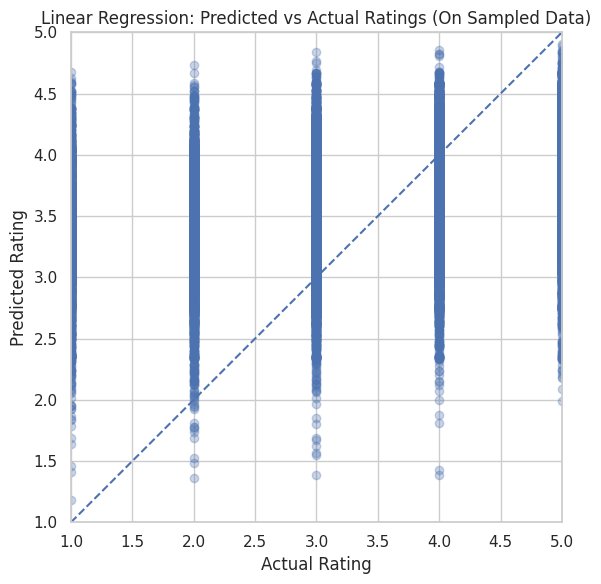

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [147]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_val, alpha=0.3)
plt.plot([1, 5], [1, 5], linestyle="--")  # perfect prediction line

plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Linear Regression: Predicted vs Actual Ratings (On Sampled Data)")

plt.xlim(1, 5)
plt.ylim(1, 5)

plt.tight_layout()
plt.savefig("images/linear_regression.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/linear_regression.png")

### Standard Errors visualization

We now generate a histogram of residuals, which is a diagnostic plot used to visualize the distribution of our prediction errors.
In Linear Regression, this is crucial for validating the model's mathematical assumptions: we want to see a symmetrical bell curve centered exactly at zero.

This shape confirms that your model's errors are random "noise" rather than systematic mistakes, proving that the model has successfully captured the underlying linear trends in the data without being biased toward over- or under-predicting.

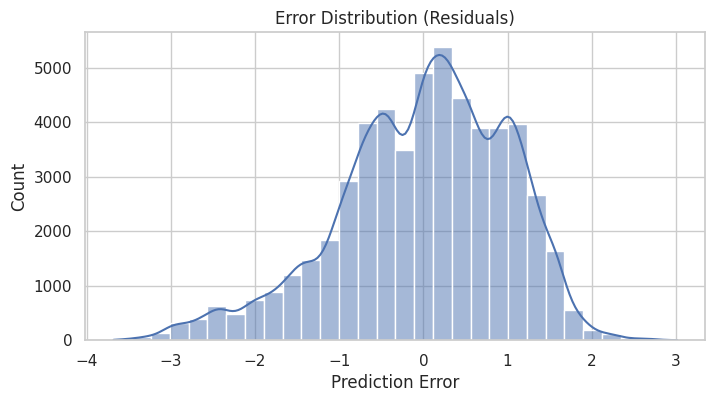

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [148]:
# Residual Plot (Checking if errors are random)
plt.figure(figsize=(8, 4))
sns.histplot(y_val - y_pred_val, kde=True, bins=30)
plt.title("Error Distribution (Residuals)")
plt.xlabel("Prediction Error")
plt.savefig("images/error_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/error_distribution.png")

### Feature Importance Analysis
We do this analysis to translate the mathematical "weights" of the model into human-readable insights by:

1. Linking Names to Numbers (zip): the model only knows the coefficients as a list of numbers (e.g., [0.26, -0.05, 0.11]), it doesn't know which number belongs to "Age" or "Price", so we use zip(feature_cols, lin_reg.coef_) to pair the human-readable names from your list with the raw numbers from the model, creating a dictionary-like link between them.

2. Ranking by Impact (sorted): the code sorts the features based on the Absolute Value (abs(x[1])) of their coefficients (a coefficient of -0.8 is just as strong/important as +0.8, the only difference is that it pushes in the opposite direction).

By sorting by magnitude, we bring the most influential factors to the top of the list, regardless of whether they are positive or negative.

3. Printing a ranked list that tells us exactly how the model thinks. We interpretate this list as follows:

- Magnitude (the number): How strongly does this feature change the rating? (e.g., 0.5 is 5x more important than 0.1).

- Direction (the sign): Positive (+), as this feature increases, the user likes the movie more; Negative (-), ss this feature increases, the user likes the movie less.

This interpretation only works because we used StandardScaler earlier: since all features are effectively in the same "units", we can fairly compare their coefficients. Without scaling, a feature like "Year" (2000) would have a tiny coefficient just because the number is big, not because it's unimportant.

The output reveals a severe case of multicollinearity (redundancy) between movie_unique_users_past and movie_total_ratings_past: because these two features likely contain almost identical information, the model assigned them massive, opposing weights (+933 and -933) to mathematically cancel each other out, meaning you should likely remove one of them to get a stable, readable model.

The "real" signals driving the rating predictions are actually the smaller, more reasonable coefficients like movie_avg_rating_past (+0.34) and user_avg_rating_past (+0.24).

In [149]:
print("\n--- Feature Importance (Linear Regression Coefficients) ---")

# feature_cols comes from your feature table builder
# If not, define it as the columns of X_train (before scaling):
# feature_cols = X_train.columns.tolist()

for name, coef in sorted(zip(feature_cols, lin_reg.coef_), key=lambda x: abs(x[1]), reverse=True):
    print(f"{name:20s}: {coef:+.5f}")

print("\nInterpretation:")
print(" - Coefficients are based on SCALED features (StandardScaler).")
print(" - A positive (+) coefficient means higher values of that feature increase predicted rating.")
print(" - A negative (-) coefficient means higher values decrease predicted rating.")
print(" - Magnitude = importance (in units of 1 standard deviation of that feature).")



--- Feature Importance (Linear Regression Coefficients) ---
movie_avg_rating_past: +0.32261
user_avg_rating_past: +0.25272
year_of_release     : -0.03712
year_missing        : -0.03281
user_unique_movies_past: -0.01804
user_total_ratings_past: -0.01804
movie_unique_users_past: -0.00758
movie_total_ratings_past: -0.00758
movie_std_rating_past: +0.00344
user_activity_days_past: +0.00266
user_std_rating_past: -0.00022

Interpretation:
 - Coefficients are based on SCALED features (StandardScaler).
 - A positive (+) coefficient means higher values of that feature increase predicted rating.
 - A negative (-) coefficient means higher values decrease predicted rating.
 - Magnitude = importance (in units of 1 standard deviation of that feature).


## **Artificial-Neural-Network (ANN) for Prediction**

We also implemented a Multi-Layer Perceptron (ANN) to capture the complex, non-linear interactions between user behavior and movie features that a simple straight line cannot see.

By stepping up from linear regression to this deep learning architecture, we test whether the model's performance is limited by simplicity or by the data itself. Furthermore, to ensure robustness, we utilized Early Stopping to halt training automatically when validation loss ceased to improve, effectively preventing overfitting.

Above, we executed the final performance validation of our Neural Network by running it against the unseen Test Set and generating specific rating predictions to see how well it generalizes to new data.

Then, we evaluate it by using:
- the built-in evaluate method to compute the raw loss,
- standard human-readable metrics like $R^2$ and $RMSE$.

This step is essential because it converts abstract loss values into concrete performance scores, allowing us to directly compare whether our Deep Learning model actually improved upon the Linear Regression baseline we established earlier.

### Interpretation of ANN results
The ANN is the superior model for this recommendation task, demonstrating both higher accuracy and stronger resilience to temporal data shifts than the Linear Regression baseline. On the test set, the ANN achieved an $R^{2}$ of 0.1538, outperforming the Linear Regression’s 0.1250, while simultaneously reducing the $RMSE$ to 1.0013 and MAE to 0.7914. While the Linear Regression model showed significant performance decay as it moved from training to testing, the ANN proved more robust by successfully capturing the non-linear relationships and complex user-content patterns that a rigid linear model misses.

In [67]:
# Build ANN
ann = Sequential()
ann.add(Dense(units=64, activation='relu', input_shape=(X_train_s.shape[1],)))
ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=1, activation='linear'))  # regression

ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping using val
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# training
history = ann.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]
)

# evaluating on the test set
test_loss, test_mae = ann.evaluate(X_test_s, y_test, verbose=0)
y_pred_test = ann.predict(X_test_s, verbose=0).ravel()

r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print("\n--- ANN Test Metrics ---")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE:        {test_mae:.4f}")
print(f"R-Squared:       {r2:.4f}")
print(f"RMSE:            {rmse:.4f}")
print(f"MAE (manual):    {mae:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 1.2815 - mae: 0.8684 - val_loss: 1.0109 - val_mae: 0.7898
Epoch 2/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.9365 - mae: 0.7650 - val_loss: 0.9972 - val_mae: 0.7861
Epoch 3/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.9281 - mae: 0.7620 - val_loss: 1.0455 - val_mae: 0.7951
Epoch 4/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.9244 - mae: 0.7594 - val_loss: 1.0007 - val_mae: 0.7946
Epoch 5/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.9222 - mae: 0.7576 - val_loss: 0.9933 - val_mae: 0.7867
Epoch 6/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.9204 - mae: 0.7583 - val_loss: 0.9949 - val_mae: 0.7876
Epoch 7/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.9225 - mae: 0.7589 - val_loss: 0.9971 - val_mae: 0.7866
Epoch 8/20
7952/7952 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.9225 - mae: 0.7580 - val_loss: 0.9960 - val_mae: 0.7844

--- ANN Test Metrics ---
Test L

In [54]:
ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,645 (33.77 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,764 (22.52 KB)

## **Random Forest for Prediction**
Our task is to predict individual ratings of each customer.
This is a regression problem since the values that y can take are 1,2,3,4 or 5.

We are now testing the Random Forest method to predict our response y.






We already have our training, validation, and test sets ready so we can build our random forests.
We want to evaluate on our validation set several Random Forest configurations with different number of trees, tree depths, and minimum leaf size.
Model performance is evaluated using $MSE$ and $R^2$. $MSE$ measures the average magnitude of prediction errors while penalizing large deviations, whereas $R^2$ indicates how much of the variance in ratings is explained by the model compared to a naive baseline.
We use NumPy to compute the square root of the mean squared error in order to obtain $RMSE$, which is easier to interpret than $MS$E.
The configuration yielding the best validation metrics will be selected for final evaluation.

Three Random Forest configurations were evaluated on a validation set. The second model, with 200 trees, maximum depth 15, and minimum leaf size 5 achieved the best validation $RMSE$ and $R^2$ and is selected for final evaluation, this time on the test set.





In [56]:
#Model 1
regressor_1 = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf = 10, #minimum number of data points allowed in a final decision
    max_features = 'sqrt', #How many features each tree is allowed to consider at each split
    criterion='squared_error',
    max_depth=20,
    random_state = 40, #Fixes randomness so results are reproducible
    n_jobs = -1 #Use all available CPU cores. Makes training much faster
)

regressor_1.fit(X_train_i, y_train)

y_val_pred_1 = regressor_1.predict(X_val_i)

rmse_1 = np.sqrt(mean_squared_error(y_val, y_val_pred_1))
r2_1   = r2_score(y_val, y_val_pred_1)

print("Model 1 - 300 trees, depth 20, leaf 10")
print("RF Validation RMSE:", round(rmse_1, 4))
print("RF Validation R2:", round(r2_1, 4))
print()


Model 1 - 300 trees, depth 20, leaf 10
RF Validation RMSE: 0.9985
RF Validation R2: 0.1607



In [70]:
#Model 2
regressor_2 = RandomForestRegressor(
    n_estimators = 200,
    min_samples_leaf= 5,
    max_features= 'sqrt',
    criterion='squared_error',
    max_depth = 15,
    random_state = 40,
    n_jobs = -1
)

regressor_2.fit(X_train_i, y_train)

y_val_pred_2 = regressor_2.predict(X_val_i)

rmse_2 = np.sqrt(mean_squared_error(y_val, y_val_pred_2))
r2_2  = r2_score(y_val, y_val_pred_2)

print("Model 2 - 200 trees, depth 15, leaf 5")
print("RF Validation RMSE:", round(rmse_2, 4))
print("RF Validation R2:", round(r2_2, 4))
print()



Model 2 - 200 trees, depth 15, leaf 5
RF Validation RMSE: 0.998
RF Validation R2: 0.1614



In [57]:
#Model 3
regressor_3 = RandomForestRegressor(
    n_estimators = 250,
    min_samples_leaf = 10,
    max_features = 'sqrt',
    criterion= 'squared_error',
    max_depth = 20,
    random_state = 40,
    n_jobs = -1
)

regressor_3.fit(X_train_i, y_train)

y_val_pred_3 = regressor_3.predict(X_val_i)

rmse_3 = np.sqrt(mean_squared_error(y_val, y_val_pred_3))
r2_3 = r2_score(y_val, y_val_pred_3)

print("Model 3 - 250 trees, depth 20, leaf 10")
print("RF Validation RMSE:", round(rmse_3, 4))
print("RF Validation R2:", round(r2_3, 4))
print()

Model 3 - 250 trees, depth 20, leaf 10
RF Validation RMSE: 0.9986
RF Validation R2: 0.1605



The following plot is a 2-feature visualization only (avg user rating vs avg movie rating). Our real model uses all 11 features, so this is just to illustrate how the classifier separates classes. Since there are millions of points in our Dataset, we scatter only a subset of them.

This plot shows the predicted movie rating as a function of the user’s average rating and the movie’s average rating. The background color represents the predicted rating in stars, while the scattered points correspond to real observations from the training set. The Random Forest produces smooth transitions across the feature space, reflecting the averaging effect of multiple trees and resulting in more stable and accurate predictions.

Interpretation of the plot:
- Predicted ratings are highest (bright yellow) in the top-right corner, where both the user and the movie have high historical averages.

- Vertical bands indicate "generous users" who rate most things highly, while horizontal bands highlight "high-quality movies" that receive good scores regardless of which user is watching.

- The jagged, color transitions prove the relationship is complex. This non-linearity is exactly why the Neural Network outperformed the Linear Regression—it can map these irregular "pockets" of preference that a straight line would miss.

- The densest cluster of points is in the center, which aligns with the peak of your Error Distribution at 0. The model is most accurate for "average" interactions but may produce the larger errors seen in the tails of your residual plot for extreme outliers in the corners.

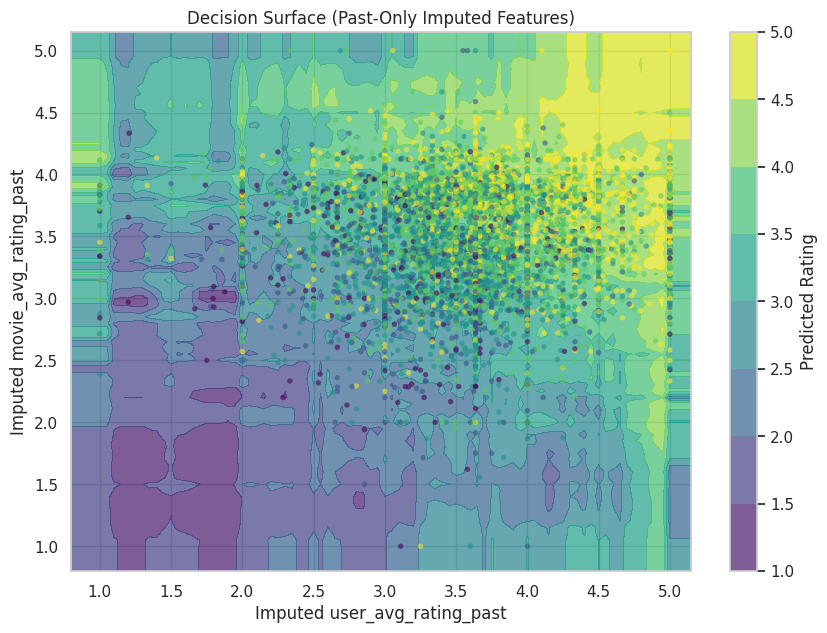

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [229]:
feat1_idx = feature_cols.index("user_avg_rating_past")
feat2_idx = feature_cols.index("movie_avg_rating_past")

# 2. Extract the processed training data
X_train_visual = X_train_i[:, [feat1_idx, feat2_idx]]
y_train_visual = y_train.values

# 3. Re-fit your specific regressor for these 2 features
# (Using a subset of features for the plot to show the decision surface)
rf_visual = regressor_2 # Your Random Forest or ANN
rf_visual.fit(X_train_visual, y_train_visual)

# 4. Create a sampling for the scatter plot to keep it responsive
random_generator = np.random.RandomState(0)
sample_indices = random_generator.choice(len(X_train_visual),
                                         size=min(8000, len(X_train_visual)),
                                         replace=False)

# 5. Setup the Grid (based on Scaled units, usually ranging from -3 to 3)
x_min, x_max = X_train_visual[:, 0].min() - 0.2, X_train_visual[:, 0].max() + 0.2
y_min, y_max = X_train_visual[:, 1].min() - 0.2, X_train_visual[:, 1].max() + 0.2

X1, X2 = np.meshgrid(
    np.arange(x_min, x_max, 0.05),
    np.arange(y_min, y_max, 0.05)
)

# 6. Predict across the grid
grid = np.array([X1.ravel(), X2.ravel()]).T
Z = rf_visual.predict(grid).reshape(X1.shape)

# 7. Plotting
plt.figure(figsize=(10, 7))

# Contour showing the model's logic
cont = plt.contourf(X1, X2, Z, alpha=0.7, cmap="viridis")

# Scatter showing actual ratings
plt.scatter(
    X_train_visual[sample_indices, 0],
    X_train_visual[sample_indices, 1],
    c=y_train_visual[sample_indices],
    cmap="viridis",
    s=15,
    edgecolor="none",
    linewidth=0.3,
    alpha=0.6
)

plt.title('Decision Surface (Past-Only Imputed Features)')
plt.xlabel(f'Imputed {feature_cols[feat1_idx]}')
plt.ylabel(f'Imputed {feature_cols[feat2_idx]}')
plt.colorbar(cont, label='Predicted Rating')
plt.savefig("images/random_forest_imputed.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/random_forest_imputed.png")



## **Decision Trees for Prediction**

After completing the Random Forest model, we proceed with the prediction phase using a Decision Tree regressor as an alternative model type.

The Decision Tree is trained on the same feature set and data splits to ensure a fair comparison with the Random Forest. The target variable y represents the outcome we aim to predict.

The prediction task is formulated as a regression problem.

We start by evaluating 3 different Decision Tree configurations with varying depths and minimum leaf sizes on the basis of the $RMSE$ and $R^2$ metrics.

From the results, the model with the lowest $RMSE$ and highest $R^2$ is the second one. Deeper trees showed worse generalization due to overfitting. When compared to Random Forest regression, even the best among these Decision Trees achieved slightly lower performance, confirming the benefit of ensemble methods in reducing variance.

In [59]:
#Model 1
dt_1= DecisionTreeRegressor(
    max_depth=20,
    criterion='squared_error',
    random_state=0,
    min_samples_leaf=10
)

dt_1.fit(X_train_i, y_train)

y_val_pred_dt_1 = dt_1.predict(X_val_i)

rmse_dt_1 = np.sqrt(mean_squared_error(y_val, y_val_pred_dt_1))
r2_dt_1 = r2_score(y_val, y_val_pred_dt_1)

print("Model 1 - depth 20, leaf 10")
print("DT Validation RMSE:", round(rmse_dt_1, 4))
print("DT Validation R2:", round(r2_dt_1, 4))
print()

#Model 2
dt_2= DecisionTreeRegressor(
    max_depth=10,
    criterion='squared_error',
    random_state=0,
    min_samples_leaf=5
)

dt_2.fit(X_train_i, y_train)

y_val_pred_dt_2 = dt_2.predict(X_val_i)

rmse_dt_2 = np.sqrt(mean_squared_error(y_val, y_val_pred_dt_2))
r2_dt_2 = r2_score(y_val, y_val_pred_dt_2)

print("Model 2 - depth 10, leaf 5")
print("DT Validation RMSE:", round(rmse_dt_2, 4))
print("DT Validation R2:", round(r2_dt_2, 4))
print()

#Model 3
dt_3= DecisionTreeRegressor(
    max_depth=25,
    criterion='squared_error',
    random_state=0,
    min_samples_leaf=15
)

dt_3.fit(X_train_i, y_train)

y_val_pred_dt_3 = dt_3.predict(X_val_i)

rmse_dt_3 = np.sqrt(mean_squared_error(y_val, y_val_pred_dt_3))
r2_dt_3 = r2_score(y_val, y_val_pred_dt_3)

print("Model 3 - depth 25, leaf 15")
print("DT Validation RMSE:", round(rmse_dt_3, 4))
print("DT Validation R2:", round(r2_dt_3, 4))
print()

Model 1 - depth 20, leaf 10
DT Validation RMSE: 1.1116
DT Validation R2: -0.0403

Model 2 - depth 10, leaf 5
DT Validation RMSE: 1.0142
DT Validation R2: 0.134

Model 3 - depth 25, leaf 15
DT Validation RMSE: 1.0979
DT Validation R2: -0.0147



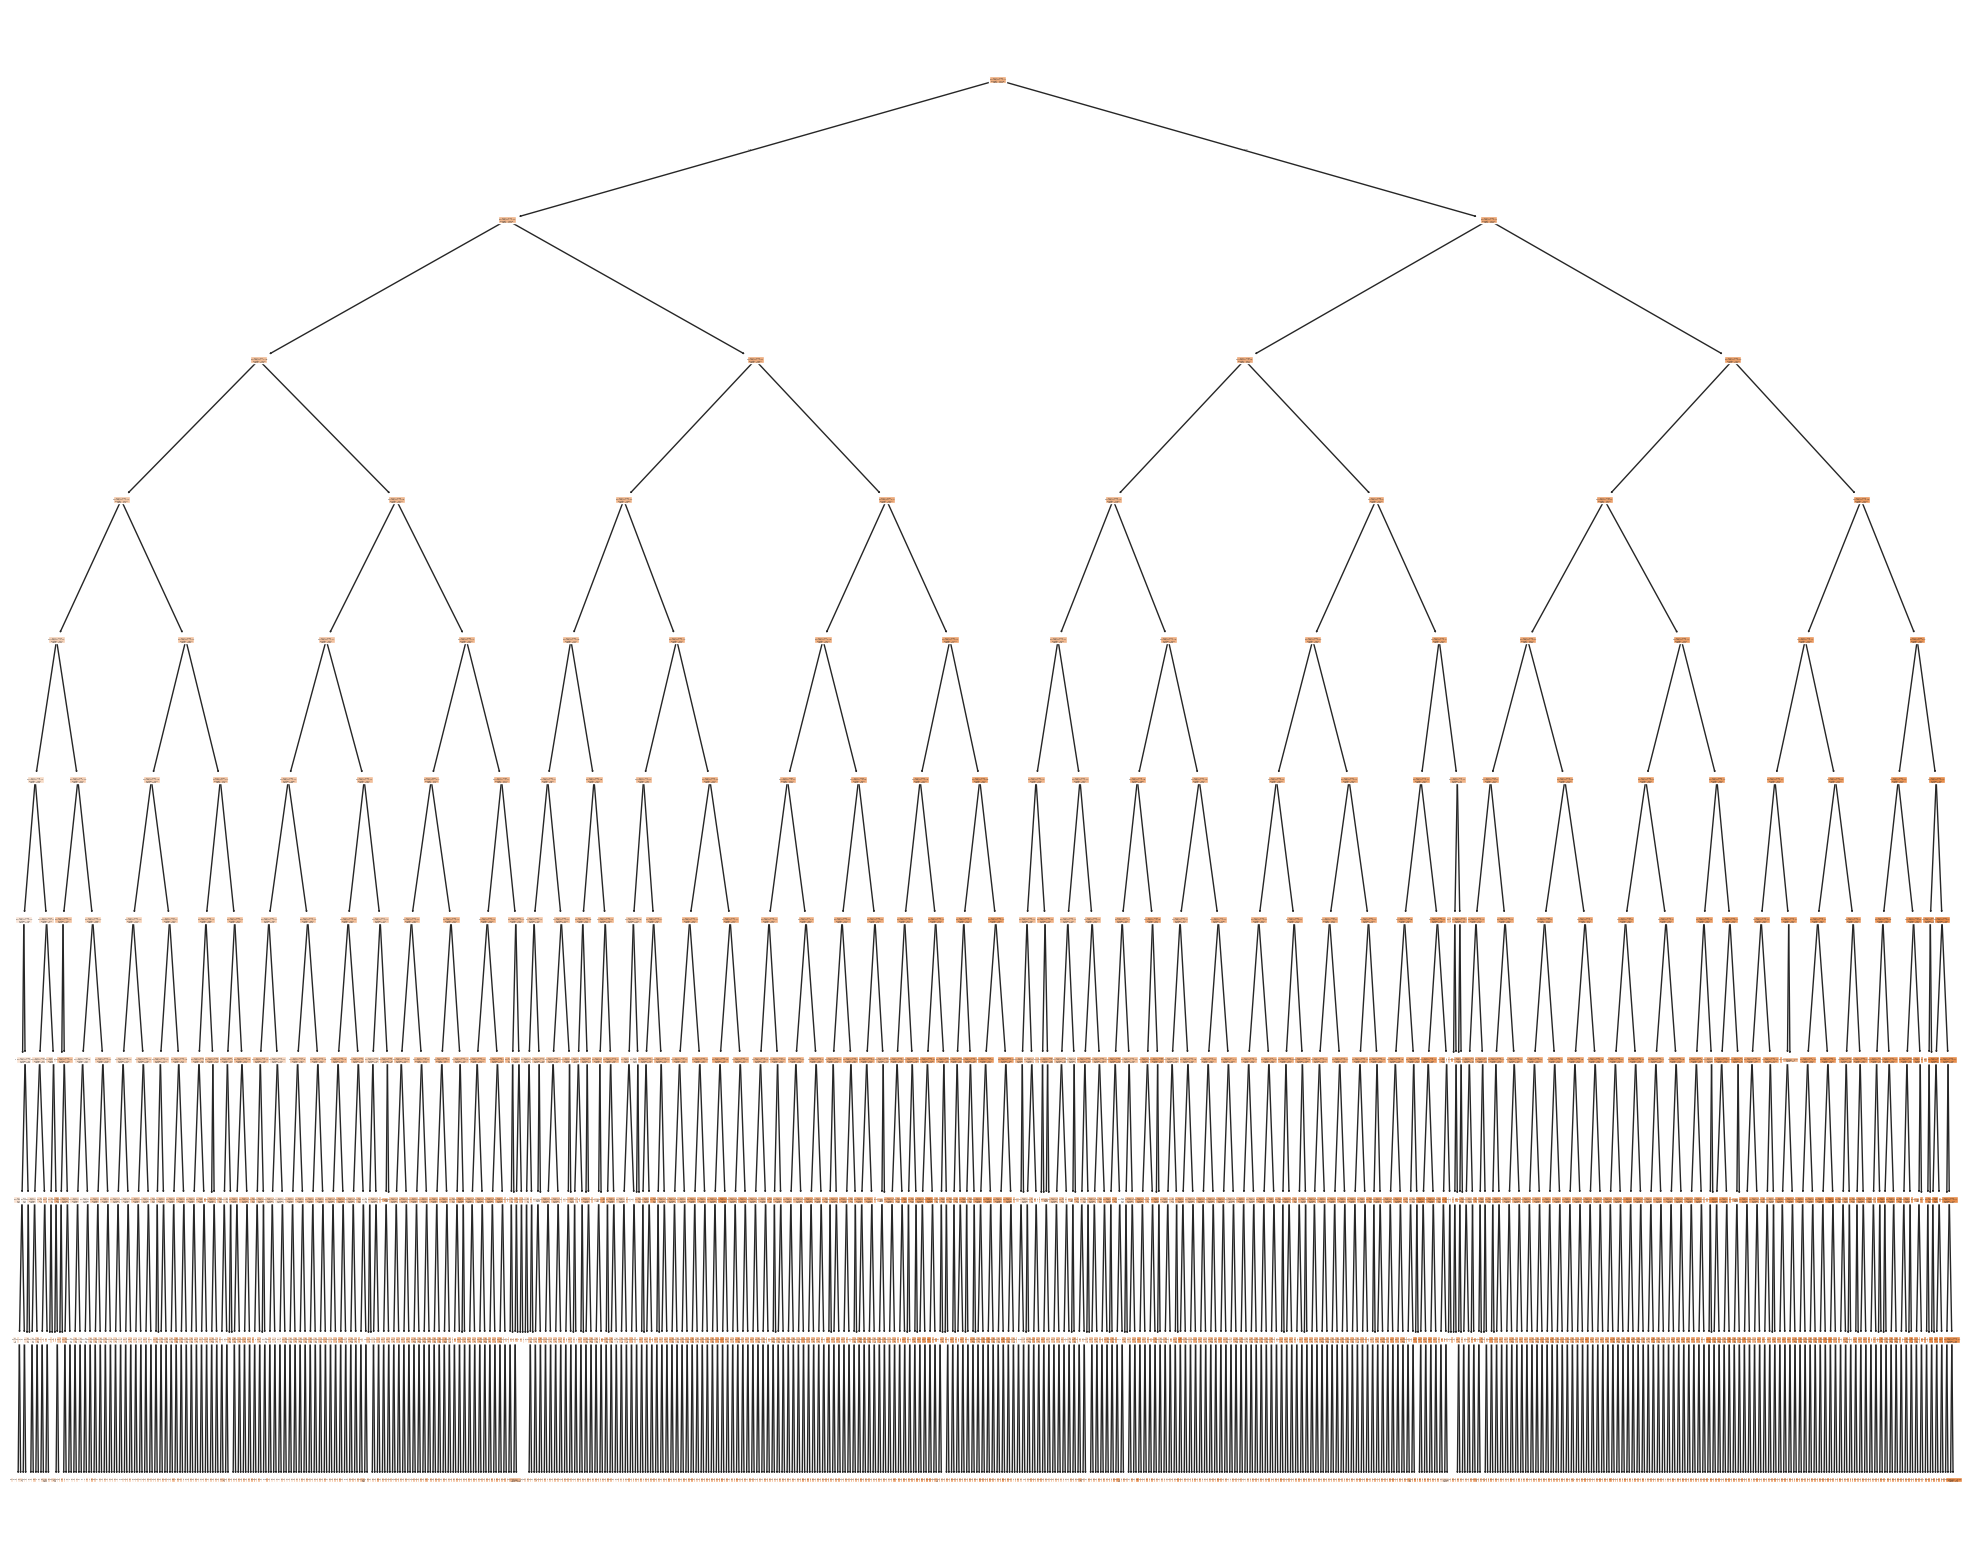

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [151]:
#Plot the winning Decision Tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_2, filled = True)
plt.savefig("images/decision_tree_diagram.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/decision_tree_diagram.png")

In [61]:
#Computing Tree Statistics
print("Tree Depth =", dt_2.get_depth())
print("Number of leaves =", dt_2.get_n_leaves())

Tree Depth = 10
Number of leaves = 893


We now pick 2 features from feature_cols to visualize and we train a decision tree on just these 2 features. The plot will show the decision boundary in a 2-feature projection, because decision regions can only be visualized in 2D.

This plot visualizes the Decision Tree’s predicted ratings using the same two features. The background color indicates the predicted rating, and the points show actual observations. The prediction surface is composed of sharp, rectangular regions, which reflects the tree’s hard split structure and explains its more rigid behavior compared to the Random Forest.

Interpretation of the plot:
- There is a clear trend where predicted ratings are highest (bright yellow) in the top-right corner. This indicates the model predicts the best scores when a historically generous user watches a historically well-rated movie.
- Vertical blocks highlight "generous users" who drive high ratings regardless of the movie, while horizontal blocks show "quality movies" that succeed regardless of the viewer.
- The fragmented "islands" in the center show the model attempting to capture subtle in the densest part of your data.

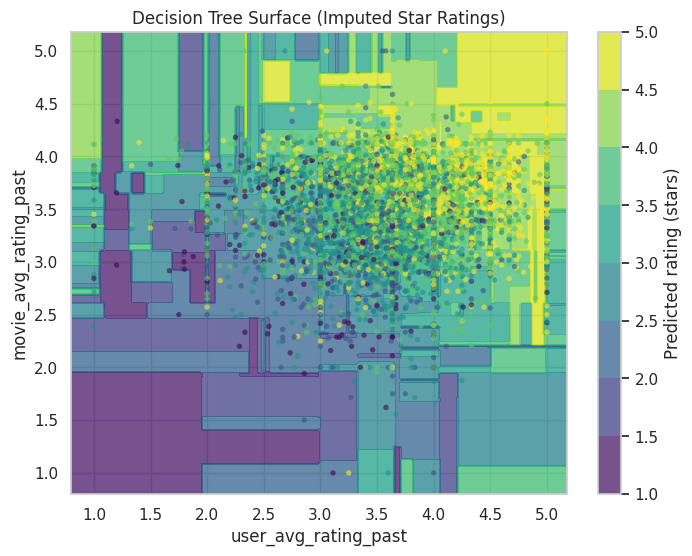

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [152]:
feature_1 = "user_avg_rating_past"
feature_2 = "movie_avg_rating_past"

# Find their integer positions in the array
feat1_idx = feature_cols.index(feature_1)
feat2_idx = feature_cols.index(feature_2)

# 2) Extract from the Imputed (unscaled) array
# This ensures we see real star ratings on the axes
X_train_visual = X_train_i[:, [feat1_idx, feat2_idx]]
y_train_visual = y_train.values

# Fitting the decision tree
dt= dt_2
dt.fit(X_train_visual, y_train_visual)

X_set, y_set = X_train_visual, y_train_visual

random_generator= np.random.RandomState(0)
sample_indices= random_generator.choice(len(X_set), size=min(8000, len(X_set)), replace=False)


# Star ratings usually stay between 1-5, so we use a tight margin
X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 0.2, stop=X_set[:, 0].max() + 0.2, step=0.02),
    np.arange(start=X_set[:, 1].min() - 0.2, stop=X_set[:, 1].max() + 0.2, step=0.02)
)

grid = np.array([X1.ravel(), X2.ravel()]).T
Z = dt.predict(grid).reshape(X1.shape)

# 5) Plotting
plt.figure(figsize=(8, 6))

# Contour plot shows the "axis-aligned" rectangles of the Decision Tree
cont = plt.contourf(X1, X2, Z, alpha=0.75, cmap="viridis")

plt.scatter(
    X_set[sample_indices, 0],
    X_set[sample_indices, 1],
    c=y_set[sample_indices],
    cmap="viridis",
    s=15,
    edgecolor="none", # Added edges to help see the dots against the background
    linewidth=0.5,
    alpha=0.6
)

plt.title('Decision Tree Surface (Imputed Star Ratings)')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.colorbar(cont, label="Predicted rating (stars)")
plt.savefig("images/decision_tree.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/decision_tree.png")

# Comparison of all models for predicting individual ratings

This plot shows us that the ANN is the optimal model as it has the highest $R^2$ value and the lowest $RMSE$ score. We acknowledge that the Linear Regression model is more interpretable but as our goal is precision focused, we opted for the model with best metrics.

/tmp/ipython-input-2938497322.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R-Squared', data=df_results, ax=ax1, palette='Blues_d', alpha=0.7)


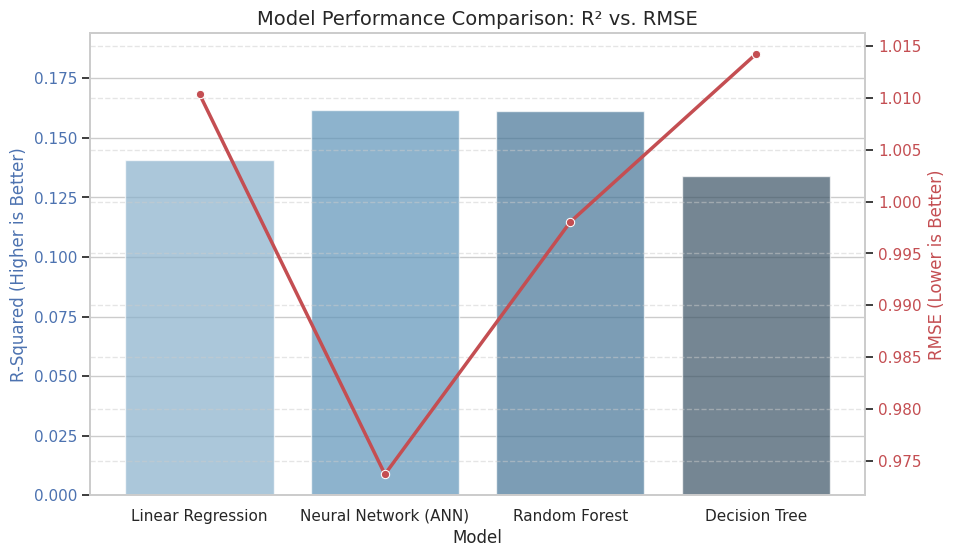

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [153]:
# 1. Prepare the data
model_data = {
    'Model': ['Linear Regression', 'Neural Network (ANN)', 'Random Forest', 'Decision Tree'],
    'R-Squared': [r2_val, r2, r2_2, r2_dt_2],  # Using your validation/test results
    'RMSE': [rmse_val, rmse, rmse_2, rmse_dt_2]
}

df_results = pd.DataFrame(model_data)

# 2. Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot R-Squared (Primary Axis)
sns.barplot(x='Model', y='R-Squared', data=df_results, ax=ax1, palette='Blues_d', alpha=0.7)
ax1.set_ylabel('R-Squared (Higher is Better)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(0, max(df_results['R-Squared']) * 1.2) # Add some space at the top

# Create a secondary axis for RMSE
ax2 = ax1.twinx()
sns.linemarker = 'o'
sns.lineplot(x='Model', y='RMSE', data=df_results, ax=ax2, color='r', marker='o', linewidth=2.5)
ax2.set_ylabel('RMSE (Lower is Better)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Model Performance Comparison: R² vs. RMSE', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig("images/prediction_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

files.download("images/prediction_performance_comparison.png")

# CONCLUSION

---
Overall, the results suggest that the greatest opportunity for platform improvement lies in aligning content exposure with distinct audience segments and evolving user preferences. Segment-aware recommendation strategies can improve user satisfaction while supporting content diversity and long-tail discovery.
